# NLP Homework 8 Code
**Noelle Brown  
MSDS 7337 Section 402**

Perform a vocabulary-based sentiment analysis of the movie reviews you used in homework 5 and homework 7, by doing the following:
1.	In Python, load one of the sentiment vocabularies referenced in the textbook, and run the sentiment analyzer as explained in the corresponding reference. Add words to the sentiment vocabulary, if you think you need to, to better fit your particular text collection.

In [1]:
# Necessary imports
import platform; print platform.platform() 
import sys; print "Python", sys.version
import nltk; print "nltk", nltk.__version__
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.corpus import sentiwordnet as swn
import bs4; print "BS4", bs4.__version__
from bs4 import BeautifulSoup, SoupStrainer
import requests; print "requests", requests.__version__
import urllib2; print "urllib2", urllib2.__version__
from urllib2 import Request, urlopen
import re; print "re", re.__version__
import os; print os.environ['CONDA_DEFAULT_ENV']
import numpy as np; print "numpy", np.__version__
import scipy; print "scipy", scipy.__version__
from scipy.stats import itemfreq
from scipy.cluster.hierarchy import ward, dendrogram
import copy
import pandas as pd; print "pandas", pd.__version__
import sklearn; print "sklearn", sklearn.__version__
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import string
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import random
import pattern; print "pattern", pattern.__version__
from pattern.en import parsetree

Darwin-17.5.0-x86_64-i386-64bit
Python 2.7.15 |Anaconda, Inc.| (default, Oct 23 2018, 13:35:16) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
nltk 3.3
BS4 4.6.3
requests 2.0.1
urllib2 2.7
re 2.2.1
Python2
numpy 1.15.3
scipy 1.1.0
pandas 0.23.4
sklearn 0.20.0
pattern 2.4


**Obtaining Reviews (Code from HW5)** 

This code pulls about half the movies with good reviews and half the movies with bad reviews, all in the animated genre.

In [2]:
# NOTE/WARNING: THIS CELL TAKES SEVERAL MINUTES TO RUN
# Reference: https://www.dataquest.io/blog/web-scraping-beautifulsoup/
# Positive reviews (animated)
url1 = "https://www.imdb.com/search/title?genres=animation&explore=title_type,genres&pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=fd0c0dd4-de47-4168-baa8-239e02fd9ee7&pf_rd_r=EJ85SEHS2WAZPGB6A52H&pf_rd_s=center-4&pf_rd_t=15051&pf_rd_i=genre&title_type=movie&sort=num_votes,desc&ref_=adv_explore_rhs"
r=requests.get(url1)
html_soup = BeautifulSoup(r.text, 'html.parser')
movie_containers = html_soup.find_all('div', class_ = 'lister-item mode-advanced')
link_list = []

# extracts just the title links to append to a base url
for movie in movie_containers:
    link = re.findall(r'"(.*?)"', str(movie.h3.a))
    link_list.append(link)

# formatting to get rid of unnecessary characters
new_link_list = []
for link in link_list:
    new_link = str(link).strip('[]').strip('\'')
    new_link_list.append(new_link)
    
# Format for URL for texts
base_url = "https://www.imdb.com{info}"

# get movie reviews using link list and base url
reviews = []
for link in new_link_list:
    movie_page = requests.get(base_url.format(info=link).decode('utf8'))
    html_soup = BeautifulSoup(movie_page.text, 'html.parser')
    review = html_soup.find('div', class_ = 'user-comments').text
    clean_review = review.split('\n')[11]
    reviews.append(clean_review)
    
# Page 2: https://www.imdb.com/search/title?title_type=feature&user_rating=1.0,5.5&num_votes=25,&genres=animation&countries=us&sort=num_votes,desc
# scaping 50 more reviews, negative reviews (animated)
url2 = "https://www.imdb.com/search/title?title_type=feature&user_rating=1.0,5.5&num_votes=25,&genres=animation&countries=us&sort=num_votes,desc"
r2=requests.get(url2)
html_soup2 = BeautifulSoup(r2.text, 'html.parser')
movie_containers2 = html_soup2.find_all('div', class_ = 'lister-item mode-advanced')
link_list2 = []

# extracts just the title links to append to a base url
for movie in movie_containers2:
    link = re.findall(r'"(.*?)"', str(movie.h3.a))
    link_list2.append(link)

# formatting to get rid of unnecessary characters
new_link_list2 = []
for link in link_list2:
    new_link = str(link).strip('[]').strip('\'')
    new_link_list2.append(new_link)

# Add these to original list of reviews
for link in new_link_list2:
    movie_page = requests.get(base_url.format(info=link).decode('utf8'))
    html_soup = BeautifulSoup(movie_page.text, 'html.parser')
    review = html_soup.find('div', class_ = 'user-comments').text
    clean_review = review.split('\n')[11]
    reviews.append(clean_review)
print reviews

[u'', u'I have enjoyed most of the computer-animated films made so far, ranging from Pixar films like "Toy Story" and "The Incredibles" to DreamWorks films like "Shrek." But "Finding Nemo" is the one that remains unparalleled, not because of its comedy or creativity, both of which are equaled in the "Toy Story" movies and in "Monsters Inc.," but because it truly, more than any of the previous computer-animated features, reinvents the genre of the children\'s animated film.Humor in traditional animation is usually based on broad slapstick and physical exaggeration. There are occasional nods to this brand of humor in "Finding Nemo," as when a flock of seagulls ram into a boat and we see their beaks crowing on the other side of the sail. But such sequences only call attention to how far this movie generally departs from old cartoon conventions. Instead, the movie invests its world of sentient animals with a surprisingly scientific texture. All of the animals are based on real species. The

In [3]:
# Get the titles of movies to add to analysis
url1 = "https://www.imdb.com/search/title?genres=animation&explore=title_type,genres&pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=fd0c0dd4-de47-4168-baa8-239e02fd9ee7&pf_rd_r=EJ85SEHS2WAZPGB6A52H&pf_rd_s=center-4&pf_rd_t=15051&pf_rd_i=genre&title_type=movie&sort=num_votes,desc&ref_=adv_explore_rhs"
r1=requests.get(url1)
html_soup1 = BeautifulSoup(r1.text, 'html.parser')
title_containers1 = html_soup1.find_all('h3', class_='lister-item-header')
title_list = []

# extracts just the titles of movies
for link in title_containers1:
    title = link.a.text
    title_list.append(title)

url2 = "https://www.imdb.com/search/title?title_type=feature&user_rating=1.0,5.5&num_votes=25,&genres=animation&countries=us&sort=num_votes,desc"
r2=requests.get(url2)
html_soup2 = BeautifulSoup(r2.text, 'html.parser')
title_containers2 = html_soup2.find_all('h3', class_='lister-item-header')

for link in title_containers2:
    title = link.a.text
    title_list.append(title)
    
print title_list

[u'WALL\xb7E', u'Finding Nemo', u'Up', u'The Lion King', u'Toy Story', u'Monsters, Inc.', u'Toy Story 3', u'How to Train Your Dragon', u'The Incredibles', u'Ratatouille', u'Shrek', u'Spirited Away', u'Inside Out', u'Frozen', u'Toy Story 2', u'Despicable Me', u'Ice Age', u'Beauty and the Beast', u'Shrek 2', u'Kung Fu Panda', u'Zootopia', u'Big Hero 6', u'Tangled', u'Despicable Me 2', u'Brave', u'Wreck-It Ralph', u'Madagascar', u'Cars', u'Aladdin', u'The Lego Movie', u'The Simpsons Movie', u'Princess Mononoke', u'Monsters University', u"Howl's Moving Castle", u'How to Train Your Dragon 2', u'The Nightmare Before Christmas', u'Shrek the Third', u"A Bug's Life", u'Coco', u'My Neighbor Totoro', u'Ice Age: The Meltdown', u'Kung Fu Panda 2', u'Corpse Bride', u'Mulan', u'Rango', u'Moana', u'The Little Mermaid', u'Finding Dory', u'Megamind', u'The Adventures of Tintin', u'The Smurfs', u'Garfield', u'Alvin and the Chipmunks', u'The Emoji Movie', u'Stuart Little 2', u'G-Force', u'Alvin and the Ch

In [4]:
# Make sure I have enough reviews
print "Number of reviews:", len(reviews)
print "Number of titles:", len(title_list)

Number of reviews: 100
Number of titles: 100


**Normalize Text**

Expand contractions, tokenize, remove stop words, remove punctuation, and lemmatize.

In [5]:
# from Sarkar pg. 287 & previous chapters
# normalize & extract features
CONTRACTION_MAP = {"ain't": "is not","aren't": "are not","can't": "cannot",
                   "can't've": "cannot have","'cause": "because","could've": "could have",
                   "couldn't": "could not","couldn't've": "could not have","didn't": "did not",
                   "doesn't": "does not","don't": "do not","hadn't": "had not",
                   "hadn't've": "had not have","hasn't": "has not","haven't": "have not",
                   "he'd": "he would","he'd've": "he would have","he'll": "he will",
                   "he'll've": "he he will have","he's": "he is","how'd": "how did",
                   "how'd'y": "how do you","how'll": "how will","how's": "how is",
                   "I'd": "I would","I'd've": "I would have","I'll": "I will",
                   "I'll've": "I will have","I'm": "I am","I've": "I have","i'd": "i would",
                   "i'd've": "i would have","i'll": "i will","i'll've": "i will have",
                   "i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would",
                   "it'd've": "it would have","it'll": "it will","it'll've": "it will have",
                   "it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not",
                   "might've": "might have","mightn't": "might not",
                   "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                   "mustn't've": "must not have","needn't": "need not","needn't've": "need not have",
                   "o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have",
                   "shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have",
                   "she'd": "she would","she'd've": "she would have","she'll": "she will",
                   "she'll've": "she will have","she's": "she is","should've": "should have",
                   "shouldn't": "should not","shouldn't've": "should not have","so've": "so have",
                   "so's": "so as","that'd": "that would","that'd've": "that would have",
                   "that's": "that is","there'd": "there would","there'd've": "there would have",
                   "there's": "there is","they'd": "they would","they'd've": "they would have",
                   "they'll": "they will","they'll've": "they will have","they're": "they are",
                   "they've": "they have","to've": "to have","wasn't": "was not","we'd": "we would",
                   "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                   "we're": "we are","we've": "we have","weren't": "were not","what'll": "what will",
                   "what'll've": "what will have","what're": "what are","what's": "what is","what've": "what have",
                   "when's": "when is","when've": "when have","where'd": "where did","where's": "where is",
                   "where've": "where have","who'll": "who will","who'll've": "who will have",
                   "who's": "who is","who've": "who have","why's": "why is","why've": "why have",
                   "will've": "will have","won't": "will not","won't've": "will not have",
                   "would've": "would have","wouldn't": "would not","wouldn't've": "would not have",
                   "y'all": "you all","y'all'd": "you all would","y'all'd've": "you all would have",
                   "y'all're": "you all are","y'all've": "you all have","you'd": "you would",
                   "you'd've": "you would have","you'll": "you will","you'll've": "you will have",
                   "you're": "you are","you've": "you have"}

def expand_contractions(sentence, contraction_mapping):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                            flags = re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expand_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expand_contraction[1:]
        return expanded_contraction
    expanded_sentence = contractions_pattern.sub(expand_match, sentence)
    return expanded_sentence

def tokenize_text(text):
    # make lowercase
    text = text.lower()
    # word tokenize
    word_tokens = word_tokenize(text) 
    return word_tokens

stop_words = set(stopwords.words('english'))  
def removestopwords_lemmatize(words):
    lmtzr = WordNetLemmatizer()
    filtered_sentence = [] 
    word_tokens = word_tokenize(words) 
    for w in word_tokens: 
        if w not in stop_words: 
            w = lmtzr.lemmatize(w)
            filtered_sentence.append(w) 
    return str(filtered_sentence)

def no_punc(s):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in s if ch not in exclude)

def normalize_text(text):
    text = expand_contractions(text, CONTRACTION_MAP)
    text = no_punc(text)
    text = removestopwords_lemmatize(text)
    return text  

### SentiWordNet

I will use the SentiWordNet sentiment lexicon to perform my sentiment analysis.

In [6]:
# Adapted from Sarkar pg. 356
def analyze_sentiment_sentiwordnet_lexicon(review, verbose=False):
    # Reviews have already been normalized & tokenized
    tagged_text = nltk.pos_tag(review)
    pos_score = neg_score = token_count = obj_score = 0
    # Get wordnet synsets based on POS tags
    # Get sentiment scores if synsets are found
    for word, tag in tagged_text:
        ss_set = None
        if 'NN' in tag and swn.senti_synsets(word, 'n'):
            ss_set = swn.senti_synsets(word, 'n')[0]
        elif 'VB' in tag and swn.senti_synsets(word, 'v'):
            ss_set = swn.senti_synsets(word, 'v')[0]
        elif 'JJ' in tag and swn.senti_synsets(word, 'a'):
            ss_set = swn.senti_synsets(word, 'a')[0]
        elif 'RB' in tag and swn.senti_synsets(word, 'r'):
            ss_set = swn.senti_synsets(word, 'r')[0]
        # if senti-synset is found
        if ss_set:
            # add scores for all found synsets
            pos_score += ss_set.pos_score()
            neg_score += ss_set.neg_score()
            obj_score += ss_set.obj_score()
            token_count += 1
    # aggregate final scores
    final_score = pos_score - neg_score
    norm_final_score = round(float(final_score) / token_count, 2)
    final_sentiment = 'positive' if norm_final_score >= 0 else 'negative'
    if verbose:
        norm_obj_score = round(float(obj_score) / token_count, 2)
        norm_pos_score = round(float(pos_score) / token_count, 2)
        norm_neg_score = round(float(neg_score) / token_count, 2)
        # to display results in a nice table
        sentiment_frame = pd.DataFrame([[final_sentiment, norm_obj_score,
                                         norm_pos_score, norm_neg_score, norm_final_score]],
                                       columns=pd.MultiIndex(levels =[['SENTIMENT STATS:'],
                                                                      ['Predicted Sentiment', 
                                                                       'Objectivity','Positive',
                                                                       'Negative', 'Overall']],
                                                             labels=[[0,0,0,0,0],[0,1,2,3,4]]))
        print sentiment_frame
    return float(norm_final_score)

In [7]:
norm_reviews = []
for review in reviews:
    if review != "":
        review = expand_contractions(review, CONTRACTION_MAP)
        review = no_punc(review)
        review = tokenize_text(review)
        norm_reviews.append(review)

final_scores = []
for review in norm_reviews:
        print "Review:"
        print review
        print analyze_sentiment_sentiwordnet_lexicon(review, verbose=True)
        final_scores.append(analyze_sentiment_sentiwordnet_lexicon(review, verbose=False))
        print '-'*60

Review:
[u'i', u'have', u'enjoyed', u'most', u'of', u'the', u'computeranimated', u'films', u'made', u'so', u'far', u'ranging', u'from', u'pixar', u'films', u'like', u'toy', u'story', u'and', u'the', u'incredibles', u'to', u'dreamworks', u'films', u'like', u'shrek', u'but', u'finding', u'nemo', u'is', u'the', u'one', u'that', u'remains', u'unparalleled', u'not', u'because', u'of', u'its', u'comedy', u'or', u'creativity', u'both', u'of', u'which', u'are', u'equaled', u'in', u'the', u'toy', u'story', u'movies', u'and', u'in', u'monsters', u'inc', u'but', u'because', u'it', u'truly', u'more', u'than', u'any', u'of', u'the', u'previous', u'computeranimated', u'features', u'reinvents', u'the', u'genre', u'of', u'the', u'childrens', u'animated', u'filmhumor', u'in', u'traditional', u'animation', u'is', u'usually', u'based', u'on', u'broad', u'slapstick', u'and', u'physical', u'exaggeration', u'there', u'are', u'occasional', u'nods', u'to', u'this', u'brand', u'of', u'humor', u'in', u'finding'

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.11     0.09    0.02
0.02
------------------------------------------------------------
Review:
[u'this', u'movie', u'is', u'quite', u'seriously', u'the', u'citizen', u'kane', u'of', u'disney', u'animation', u'every', u'animated', u'movie', u'from', u'disney', u'ever', u'since', u'has', u'been', u'a', u'failed', u'attempt', u'to', u'recreate', u'the', u'masterpiece', u'that', u'this', u'film', u'is', u'this', u'movie', u'is', u'an', u'anomaly', u'in', u'a', u'market', u'usually', u'dominated', u'by', u'formulaic', u'kiddiefare', u'unlike', u'most', u'films', u'from', u'animation', u'studios', u'this', u'movie', u'will', u'enthrall', u'you', u'whether', u'you', u'are', u'5', u'years', u'old', u'or', u'50', u'an', u'epic', u'plot', u'intriguing', u'characters', u'great', u'music', u'and', u'hillarious', u'moments', u'make', u'this',

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.86     0.08     0.06    0.03
0.03
------------------------------------------------------------
Review:
[u'hiccup', u'a', u'young', u'viking', u'befriends', u'toothless', u'a', u'young', u'dragon', u'this', u'is', u'the', u'best', u'movie', u'i', u'have', u'seen', u'since', u'the', u'lord', u'of', u'the', u'rings', u'trilogy', u'virtually', u'everything', u'about', u'it', u'is', u'wonderful', u'rarely', u'have', u'i', u'been', u'so', u'drawn', u'in', u'to', u'an', u'animated', u'movie', u'the', u'3d', u'aspects', u'are', u'thrilling', u'and', u'the', u'movie', u'has', u'a', u'great', u'story', u'amazing', u'animation', u'non', u'stop', u'action', u'and', u'a', u'positive', u'and', u'constructive', u'message', u'it', u'made', u'me', u'want', u'to', u'go', u'out', u'and', u'get', u'a', u'pet', u'dragon', u'this', u'movie', u'is', u'perfect'

------------------------------------------------------------
Review:
[u'i', u'am', u'not', u'normally', u'one', u'to', u'write', u'reviews', u'but', u'i', u'could', u'not', u'help', u'reading', u'several', u'for', u'this', u'film', u'on', u'this', u'site', u'that', u'just', u'didt', u'seem', u'to', u'understand', u'where', u'i', u'think', u'the', u'film', u'was', u'supposed', u'to', u'be', u'coming', u'fromthe', u'majority', u'of', u'the', u'complaints', u'i', u'saw', u'were', u'that', u'the', u'film', u'was', u'too', u'depressing', u'for', u'a', u'childrens', u'film', u'but', u'whilst', u'i', u'see', u'where', u'they', u'are', u'coming', u'from', u'in', u'some', u'regards', u'every', u'child', u'who', u'i', u'have', u'seen', u'watch', u'this', u'film', u'i', u'work', u'in', u'a', u'cinema', u'has', u'absolutely', u'loved', u'it', u'and', u'laughed', u'out', u'loud', u'almost', u'constantly', u'they', u'are', u'not', u'old', u'enough', u'to', u'realise', u'the', u'message', u'the', u'f

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.87     0.06     0.06    -0.0
-0.0
------------------------------------------------------------
Review:
[u'despicable', u'me', u'is', u'simply', u'hilarious', u'this', u'movie', u'is', u'not', u'just', u'for', u'kids', u'adults', u'are', u'going', u'to', u'enjoy', u'it', u'even', u'more', u'the', u'youngest', u'girl', u'in', u'it', u'is', u'sooooooo', u'cute', u'also', u'the', u'small', u'yellow', u'minions', u'simply', u'adorable', u'and', u'so', u'funny', u'the', u'entire', u'hall', u'was', u'laughing', u'through', u'out', u'the', u'moviethe', u'plot', u'is', u'very', u'interesting', u'to', u'keep', u'you', u'engrossed', u'throughout', u'the', u'movieit', u'is', u'not', u'a', u'very', u'original', u'plot', u'but', u'has', u'the', u'very', u'humorous', u'dialogs', u'and', u'actssteve', u'carells', u'is', u'simply', u'amazing', u'he', u'i

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.83     0.11     0.06    0.05
0.05
------------------------------------------------------------
Review:
[u'so', u'despicable', u'me', u'2', u'is', u'a', u'very', u'family', u'funnyfriendly', u'animated', u'comedy', u'which', u'at', u'points', u'really', u'does', u'make', u'you', u'laugh', u'if', u'you', u'are', u'reading', u'this', u'now', u'and', u'have', u'not', u'yet', u'seen', u'the', u'trailer', u'i', u'would', u'recommend', u'you', u'do', u'not', u'watch', u'the', u'trailer', u'and', u'just', u'go', u'straight', u'to', u'the', u'film', u'some', u'of', u'the', u'best', u'parts', u'are', u'shown', u'in', u'the', u'trailer', u'to', u'watch', u'this', u'film', u'you', u'do', u'not', u'really', u'need', u'to', u'have', u'seen', u'the', u'first', u'however', u'i', u'would', u'recommend', u'you', u'do', u'as', u'at', u'points', u'the', u'f

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.83      0.1     0.07    0.03
0.03
------------------------------------------------------------
Review:
[u'let', u'me', u'start', u'by', u'saying', u'this', u'i', u'am', u'the', u'ideal', u'demographic', u'for', u'this', u'movie', u'i', u'am', u'in', u'my', u'earlymid', u'30s', u'i', u'grew', u'up', u'with', u'videos', u'games', u'starting', u'with', u'the', u'colecovision', u'30', u'years', u'ago', u'which', u'is', u'in', u'the', u'movie', u'when', u'wreckit', u'ralph', u'was', u'released', u'i', u'still', u'play', u'games', u'i', u'have', u'a', u'fouryearold', u'son', u'who', u'plays', u'games', u'he', u'knows', u'who', u'pacman', u'zangief', u'and', u'sonic', u'are', u'and', u'you', u'can', u'bet', u'that', u'on', u'top', u'of', u'that', u'i', u'know', u'who', u'sheng', u'long', u'tapper', u'qbert', u'and', u'burger', u'time', u'aretha

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.8     0.12     0.08    0.04
0.04
------------------------------------------------------------
Review:
[u'as', u'usual', u'you', u'have', u'got', u'ta', u'hand', u'it', u'to', u'pixarin', u'cars', u'their', u'latest', u'film', u'they', u'show', u'why', u'they', u'are', u'still', u'the', u'cream', u'of', u'the', u'crop', u'when', u'it', u'comes', u'to', u'the', u'field', u'they', u'revolutionized', u'more', u'than', u'a', u'decade', u'ago', u'well', u'yeah', u'it', u'does', u'not', u'have', u'the', u'sophistication', u'and', u'cleverness', u'of', u'the', u'incredibles', u'nor', u'the', u'universal', u'appeal', u'of', u'both', u'toy', u'stories', u'and', u'finding', u'nemo', u'and', u'i', u'have', u'to', u'admit', u'that', u'the', u'idea', u'of', u'animated', u'cars', u'was', u'the', u'least', u'riveting', u'as', u'far', u'as', u'pixar', u

------------------------------------------------------------
Review:
[u'as', u'a', u'longtime', u'fan', u'of', u'the', u'simpsons', u'i', u'myself', u'eagerly', u'waited', u'for', u'the', u'movie', u'to', u'come', u'out', u'as', u'early', u'as', u'the', u'mid90s', u'when', u'the', u'itchy', u'and', u'scratchy', u'movie', u'episode', u'came', u'out', u'whose', u'ideals', u'i', u'felt', u'would', u'make', u'their', u'way', u'into', u'an', u'eventual', u'simpsons', u'movie', u'over', u'the', u'years', u'it', u'had', u'seemed', u'unfortunate', u'that', u'the', u'quality', u'of', u'the', u'show', u'had', u'been', u'declining', u'jokes', u'that', u'lacked', u'luster', u'and', u'a', u'feeling', u'that', u'the', u'show', u'was', u'attempting', u'to', u'compete', u'with', u'a', u'bit', u'lower', u'brow', u'show', u'family', u'guy', u'at', u'a', u'level', u'that', u'it', u'did', u'not', u'seem', u'to', u'ever', u'belong', u'i', u'waited', u'with', u'anticipation', u'hoping', u'that', u'the', u'm

------------------------------------------------------------
Review:
[u'pixar', u'is', u'the', u'source', u'of', u'some', u'of', u'the', u'most', u'deep', u'thoughtful', u'and', u'meaningful', u'cg', u'films', u'and', u'have', u'created', u'a', u'great', u'name', u'for', u'themselves', u'personally', u'i', u'love', u'most', u'of', u'their', u'films', u'i', u'almost', u'joined', u'the', u'naysayers', u'prior', u'to', u'this', u'films', u'release', u'before', u'reminding', u'myself', u'that', u'pixar', u'has', u'never', u'really', u'let', u'me', u'down', u'and', u'as', u'expected', u'excellence', u'reigned', u'supreme', u'this', u'is', u'in', u'my', u'opinion', u'a', u'really', u'good', u'film', u'perhaps', u'not', u'at', u'the', u'level', u'of', u'up', u'and', u'walle', u'but', u'it', u'is', u'certainly', u'not', u'bad', u'eitheranimation', u'a', u'the', u'animation', u'is', u'fantastic', u'then', u'again', u'what', u'else', u'can', u'be', u'expected', u'from', u'pixar', u'top', u'quali

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.77     0.13      0.1    0.03
0.03
------------------------------------------------------------
Review:
[u'by', u'1993', u'director', u'tim', u'burton', u'was', u'such', u'a', u'successful', u'filmmaker', u'in', u'hollywood', u'that', u'he', u'was', u'able', u'to', u'return', u'to', u'one', u'of', u'his', u'most', u'beloved', u'early', u'projects', u'the', u'nightmare', u'before', u'christmas', u'it', u'is', u'certainly', u'an', u'inspired', u'movie', u'as', u'it', u'is', u'also', u'very', u'weird', u'and', u'when', u'i', u'say', u'weird', u'i', u'mean', u'it', u'is', u'distinctly', u'burtoneven', u'though', u'it', u'was', u'directed', u'with', u'enough', u'competency', u'by', u'henry', u'selick', u'this', u'groundbreaking', u'stopmotion', u'animation', u'film', u'is', u'burton', u'all', u'the', u'way', u'as', u'it', u'contains', u'ample'

------------------------------------------------------------
Review:
[u'i', u'first', u'watched', u'this', u'film', u'in', u'japanese', u'with', u'a', u'12', u'year', u'old', u'translating', u'for', u'me', u'and', u'i', u'still', u'thought', u'it', u'was', u'incredible', u'there', u'are', u'so', u'many', u'wonderful', u'touches', u'like', u'a', u'tin', u'can', u'in', u'the', u'stream', u'while', u'the', u'kids', u'are', u'fascinated', u'by', u'a', u'fish', u'or', u'the', u'flying', u'scenes', u'i', u'am', u'convinced', u'that', u'ang', u'lee', u'thought', u'of', u'miyazaki', u'when', u'he', u'made', u'the', u'hulk', u'just', u'in', u'terms', u'of', u'the', u'jumping', u'scenes', u'that', u'show', u'a', u'curious', u'mind', u'at', u'work', u'throughout', u'the', u'picture', u'i', u'also', u'love', u'the', u'sense', u'of', u'magic', u'and', u'innocence', u'and', u'the', u'lack', u'of', u'violence', u'which', u'pervades', u'the', u'movie', u'it', u'is', u'a', u'real', u'antidote', u'from'

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.79     0.15     0.06    0.09
0.09
------------------------------------------------------------
Review:
[u'mulan', u'is', u'a', u'young', u'girl', u'in', u'ancient', u'china', u'when', u'the', u'huns', u'start', u'attacking', u'the', u'country', u'the', u'emperor', u'orders', u'one', u'member', u'of', u'every', u'family', u'to', u'join', u'the', u'chinese', u'army', u'and', u'defend', u'the', u'country', u'the', u'one', u'member', u'must', u'be', u'a', u'man', u'but', u'in', u'mulans', u'family', u'the', u'only', u'male', u'is', u'her', u'injured', u'father', u'not', u'wanting', u'to', u'allow', u'her', u'father', u'to', u'die', u'mulan', u'dresses', u'like', u'a', u'man', u'and', u'escapes', u'into', u'the', u'night', u'to', u'join', u'the', u'war', u'to', u'protect', u'her', u'the', u'ancient', u'elders', u'of', u'her', u'family', u'ask

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.79     0.14     0.07    0.07
0.07
------------------------------------------------------------
Review:
[u'sometimes', u'there', u'are', u'films', u'that', u'are', u'untouchable', u'and', u'i', u'think', u'something', u'like', u'finding', u'nemo', u'was', u'one', u'of', u'them', u'whilst', u'dory', u'was', u'a', u'beloved', u'character', u'in', u'the', u'film', u'i', u'believe', u'it', u'was', u'a', u'stretch', u'having', u'her', u'become', u'the', u'star', u'of', u'her', u'own', u'film', u'in', u'finding', u'dorythe', u'other', u'problem', u'with', u'creating', u'spinoff', u'films', u'or', u'sequels', u'and', u'remakes', u'for', u'that', u'matter', u'is', u'that', u'you', u'find', u'yourself', u'consistently', u'comparing', u'them', u'to', u'the', u'original', u'this', u'can', u'be', u'detrimental', u'if', u'the', u'original', u'was', u'

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.84     0.11     0.05    0.05
0.05
------------------------------------------------------------
Review:
[u'i', u'am', u'amazed', u'that', u'the', u'average', u'mark', u'for', u'this', u'film', u'is', u'so', u'low', u'the', u'film', u'is', u'very', u'much', u'made', u'in', u'the', u'spirit', u'of', u'the', u'cartoons', u'and', u'the', u'live', u'action', u'mixed', u'with', u'cartoon', u'special', u'effects', u'works', u'really', u'well', u'the', u'key', u'thing', u'though', u'is', u'the', u'performance', u'of', u'hank', u'azaria', u'as', u'gargamel', u'he', u'is', u'perfectly', u'cast', u'a', u'panto', u'villain', u'i', u'loved', u'him', u'doogie', u'howser', u'is', u'perfectly', u'likable', u'as', u'is', u'his', u'screen', u'wife', u'it', u'is', u'a', u'nice', u'film', u'to', u'watch', u'entertaining', u'and', u'surely', u'ideal', u'for',

------------------------------------------------------------
Review:
[u'first', u'off', u'i', u'enjoyed', u'this', u'movie', u'immenselynot', u'only', u'does', u'this', u'movie', u'familyfriendly', u'with', u'absolutely', u'zero', u'content', u'that', u'are', u'controversial', u'too', u'highend', u'derogative', u'or', u'political', u'but', u'most', u'of', u'all', u'it', u'inspired', u'me', u'a', u'lot', u'quite', u'frankly', u'this', u'story', u'caused', u'my', u'mind', u'to', u'explode', u'with', u'a', u'bit', u'of', u'imagination', u'stuart', u'and', u'margalo', u'opened', u'up', u'a', u'whole', u'new', u'universe', u'flashbacks', u'from', u'the', u'first', u'film', u'reminded', u'me', u'that', u'first', u'we', u'saw', u'stuart', u'was', u'in', u'an', u'orphanage', u'and', u'that', u'is', u'that', u'and', u'all', u'mrs', u'keeper', u'mentioned', u'about', u'stuarts', u'parents', u'was', u'that', u'they', u'were', u'smashed', u'by', u'falling', u'cans', u'which', u'in', u'certain', u'

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.82      0.1     0.08    0.01
0.01
------------------------------------------------------------
Review:
[u'i', u'did', u'not', u'know', u'this', u'was', u'a', u'childrens', u'movie', u'after', u'all', u'shrek', u'monsters', u'inc', u'toy', u'story', u'etc', u'appeal', u'to', u'children', u'but', u'are', u'also', u'squarely', u'aimed', u'at', u'adults', u'garfield', u'tale', u'of', u'two', u'kitties', u'is', u'squarely', u'aimed', u'at', u'younger', u'folk', u'with', u'a', u'few', u'mild', u'chuckles', u'for', u'the', u'parents', u'it', u'was', u'colorful', u'well', u'done', u'excellent', u'quality', u'etc', u'but', u'let', u'us', u'face', u'it', u'by', u'being', u'designed', u'for', u'510', u'yearolds', u'it', u'also', u'had', u'to', u'be', u'really', u'sloooooooowbrekin', u'myer', u'is', u'a', u'charming', u'actor', u'with', u'good', u'v

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.82     0.09     0.08    0.01
0.01
------------------------------------------------------------
Review:
[u'to', u'begin', u'with', u'the', u'g', u'rating', u'is', u'all', u'wrong', u'this', u'is', u'a', u'pg', u'movie', u'but', u'obviously', u'and', u'attempt', u'to', u'lower', u'the', u'g', u'movie', u'standards', u'as', u'they', u'did', u'with', u'pg', u'movies', u'20', u'years', u'ago', u'i', u'originally', u'gave', u'this', u'movie', u'3', u'stars', u'but', u'changed', u'it', u'to', u'4', u'just', u'because', u'i', u'actually', u'like', u'those', u'little', u'furry', u'guys', u'it', u'is', u'not', u'really', u'their', u'fault', u'that', u'the', u'writers', u'producers', u'and', u'directors', u'made', u'a', u'couple', u'of', u'big', u'mistakes', u'during', u'this', u'movie', u'in', u'a', u'g', u'movies', u'there', u'is', u'not', u'supp

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.82     0.09     0.09    0.01
0.01
------------------------------------------------------------
Review:
[u'ralph', u'bakshi', u'the', u'very', u'name', u'conjures', u'up', u'such', u'successes', u'and', u'groundbreaking', u'movies', u'as', u'fritz', u'the', u'cat', u'heavy', u'traffic', u'the', u'tabooshattering', u'coonskin', u'and', u'even', u'later', u'triumphs', u'as', u'american', u'pop', u'he', u'even', u'made', u'good', u'in', u'reanimating', u'cartoon', u'versions', u'of', u'spiderman', u'and', u'mighty', u'mouse', u'i', u'even', u'remember', u'the', u'funny', u'characters', u'he', u'created', u'for', u'that', u'video', u'for', u'the', u'rolling', u'stones', u'harlem', u'shuffleso', u'why', u'did', u'his', u'usual', u'command', u'of', u'the', u'medium', u'slide', u'down', u'so', u'much', u'in', u'quality', u'with', u'cool', u'worl

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.82      0.1     0.08    0.02
0.02
------------------------------------------------------------
Review:
[u'it', u'has', u'been', u'nearly', u'five', u'years', u'since', u'the', u'release', u'of', u'this', u'recent', u'traditionally', u'animated', u'disney', u'flick', u'made', u'in', u'a', u'cgidominated', u'time', u'and', u'i', u'definitely', u'did', u'not', u'even', u'hear', u'about', u'it', u'at', u'the', u'time', u'of', u'its', u'release', u'it', u'clearly', u'did', u'not', u'turn', u'out', u'to', u'be', u'a', u'box', u'office', u'smash', u'which', u'is', u'probably', u'why', u'i', u'never', u'heard', u'about', u'it', u'unlike', u'the', u'incredibles', u'the', u'hugely', u'successful', u'cgianimated', u'feature', u'released', u'the', u'same', u'year', u'and', u'i', u'do', u'not', u'think', u'i', u'knew', u'about', u'it', u'until', u'i'

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.8     0.12     0.08    0.04
0.04
------------------------------------------------------------
Review:
[u'i', u'can', u'not', u'believe', u'how', u'this', u'great', u'family', u'movie', u'is', u'so', u'underrated', u'despite', u'the', u'fact', u'it', u'is', u'a', u'terrific', u'movieme', u'and', u'my', u'dear', u'son', u'muhammad', u'enjoyed', u'watching', u'this', u'perfect', u'family', u'movie', u'from', u'the', u'beginning', u'to', u'the', u'end', u'the', u'low', u'ratings', u'does', u'not', u'clearly', u'prove', u'that', u'the', u'film', u'is', u'badalsothe', u'negative', u'comments', u'by', u'movie', u'critics', u'and', u'imdb', u'critics', u'do', u'not', u'necessarily', u'mean', u'that', u'this', u'movie', u'is', u'bad', u'at', u'allit', u'is', u'important', u'to', u'tell', u'you', u'that', u'this', u'film', u'alvin', u'and', u'the

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.84     0.09     0.07    0.02
0.02
------------------------------------------------------------
Review:
[u'have', u'you', u'seen', u'movies', u'that', u'almost', u'wore', u'you', u'out', u'after', u'45', u'minutes', u'im', u'talking', u'about', u'too', u'much', u'action', u'too', u'much', u'bickering', u'and', u'yelling', u'between', u'people', u'too', u'much', u'happening', u'the', u'screen', u'too', u'loudjust', u'too', u'much', u'you', u'want', u'to', u'cry', u'enough', u'alreadygive', u'us', u'a', u'few', u'lulls', u'that', u'is', u'how', u'found', u'this', u'cuteatfirst', u'animated', u'film', u'which', u'starts', u'off', u'great', u'but', u'quickly', u'spirals', u'into', u'the', u'too', u'much', u'category', u'and', u'never', u'lets', u'go', u'maybe', u'i', u'am', u'just', u'too', u'old', u'for', u'this', u'sort', u'of', u'thing', u

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.12     0.07    0.04
0.04
------------------------------------------------------------
Review:
[u'you', u'know', u'this', u'review', u'is', u'not', u'based', u'on', u'the', u'premise', u'that', u'this', u'is', u'an', u'egregious', u'film', u'it', u'is', u'i', u'agree', u'that', u'this', u'film', u'is', u'abhorrent', u'however', u'the', u'legend', u'surrounding', u'this', u'lukewarm', u'atrocious', u'piece', u'of', u'media', u'is', u'far', u'more', u'enjoyable', u'than', u'this', u'pile', u'of', u'excrement', u'this', u'ahem', u'film', u'came', u'out', u'december', u'of', u'2012', u'it', u'was', u'supposed', u'to', u'come', u'out', u'in', u'december', u'of', u'2002', u'the', u'film', u'was', u'stolen', u'and', u'that', u'was', u'probably', u'for', u'the', u'best', u'however', u'because', u'the', u'directors', u'had', u'faith', u'o

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.85     0.09     0.06    0.03
0.03
------------------------------------------------------------
Review:
[u'i', u'disagree', u'with', u'spider63', u'i', u'happened', u'upon', u'this', u'movie', u'switching', u'channels', u'one', u'day', u'and', u'after', u'just', u'a', u'few', u'minutes', u'i', u'was', u'hooked', u'i', u'loved', u'dom', u'deluises', u'voice', u'in', u'this', u'i', u'can', u'see', u'where', u'some', u'folks', u'may', u'think', u'it', u'a', u'little', u'corny', u'and', u'it', u'does', u'have', u'an', u'older', u'movie', u'feel', u'but', u'the', u'story', u'kept', u'me', u'glued', u'to', u'the', u'tv', u'and', u'i', u'hope', u'to', u'get', u'a', u'copy', u'of', u'it', u'one', u'of', u'these', u'days', u'it', u'is', u'a', u'darling', u'movie', u'and', u'refreshing', u'to', u'see', u'something', u'enjoyable', u'as', u'this', u'

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.12     0.07    0.05
0.05
------------------------------------------------------------
Review:
[u'i', u'did', u'love', u'the', u'fact', u'that', u'the', u'movie', u'was', u'a', u'stop', u'motion', u'animated', u'film', u'and', u'it', u'does', u'have', u'a', u'few', u'laugh', u'out', u'loud', u'jokes', u'plus', u'it', u'is', u'a', u'nice', u'hard', u'rated', u'r', u'as', u'well', u'filled', u'with', u'mostly', u'really', u'dirty', u'jokesbut', u'overall', u'the', u'movie', u'is', u'pretty', u'weak', u'that', u'may', u'explain', u'why', u'i', u'did', u'not', u'hear', u'about', u'it', u'until', u'i', u'just', u'happen', u'to', u'past', u'the', u'movie', u'theater', u'and', u'saw', u'the', u'poster', u'especially', u'considering', u'what', u'an', u'all', u'star', u'cast', u'of', u'voice', u'overs', u'that', u'are', u'featured', u'in'

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.9     0.06     0.04    0.02
0.02
------------------------------------------------------------
Review:
[u'it', u'is', u'sad', u'there', u'was', u'so', u'much', u'hope', u'in', u'me', u'that', u'the', u'little', u'guy', u'could', u'stare', u'down', u'the', u'hollywood', u'gods', u'in', u'this', u'case', u'pixar', u'and', u'dreamworks', u'and', u'come', u'out', u'a', u'winner', u'i', u'new', u'going', u'in', u'that', u'this', u'film', u'had', u'problems', u'no', u'advertising', u'no', u'studio', u'release', u'backing', u'many', u'production', u'trials', u'a', u'relatively', u'expensive', u'cast', u'of', u'voice', u'actors', u'for', u'a', u'venture', u'of', u'this', u'type', u'still', u'i', u'had', u'hopewhat', u'i', u'was', u'left', u'with', u'was', u'oh', u'how', u'glad', u'i', u'am', u'that', u'few', u'will', u'see', u'this', u'film', u'

2.	For each of the clusters you created in homework 7, compute the average, median, high, and low sentiment scores for each cluster. Explain whether you think this reveals anything interesting about the clusters.

I am going to use k-means clusters with k=3 from my HW7 code. I felt as though the 3 clusters provided the most distinct clusters with the least amount of crossover.

### K-Means Clustering

In [8]:
# build feature matrix from Sarkar pg. 270
def build_feature_matrix(documents, feature_type='frequency', ngram_range=(1, 1), min_df=0.0, max_df=1.0):
    feature_type = feature_type.lower().strip()
    if feature_type == 'binary':
        vectorizer = CountVectorizer(binary=True, min_df=min_df, max_df=max_df, ngram_range=ngram_range)
    elif feature_type == 'frequency':
        vectorizer = CountVectorizer(binary=False, min_df=min_df, max_df=max_df, ngram_range=ngram_range)
    elif feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, ngram_range=ngram_range)
    else:
        raise Exception("Wrong feature type entered. Possible values:'binary', 'frequency','tfidf'")
    feature_matrix = vectorizer.fit_transform(documents).astype(float)
    return vectorizer, feature_matrix

In [9]:
# remove blank reviews
blank_indices = []
for i in range(0, len(reviews)):
    if reviews[i] == '':
        blank_indices.append(i)
print blank_indices

[0, 5, 10, 16, 17, 18, 34, 71, 76, 98]


In [10]:
# remove blank reviews in title list
# https://stackoverflow.com/questions/497426/deleting-multiple-elements-from-a-list
title_list = [i for j, i in enumerate(title_list) if j not in blank_indices]

In [18]:
norm_reviews1 = []
for review in reviews:
    if review != "":
        #review = normalize_text(review)
        review = review.lower()
        review = expand_contractions(review, CONTRACTION_MAP)
        review = no_punc(review)
        review = removestopwords_lemmatize(review)
        norm_reviews1.append(review)
    
# extract tf-idf features from Sarkar pg. 300
vectorizer, feature_matrix = build_feature_matrix(norm_reviews1, feature_type='tfidf',
                                                  min_df=0.24, max_df=0.85, ngram_range=(1, 2))
# view number of features
print feature_matrix.shape
# get feature names
feature_names = vectorizer.get_feature_names()
# print sample features
print feature_names[:20]

(90, 38)
[u'also', u'animated', u'animation', u'best', u'character', u'could', u'even', u'film', u'first', u'funny', u'get', u'give', u'go', u'good', u'great', u'kid', u'like', u'little', u'love', u'made']


In [20]:
# convert to df for further work
reviewdf = pd.DataFrame(np.column_stack([title_list, norm_reviews1, final_scores]),  columns=['Title', 'Reviews', 'Scores'])

In [21]:
# K-means from Sarkar pg. 302
# define the k-means clustering function
def k_means(feature_matrix, num_clusters):
    km = KMeans(n_clusters=num_clusters, max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

def get_cluster_data(clustering_obj, movie_data, feature_names, num_clusters, topn_features=10):
    cluster_details = {}
    # get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # get key features for each cluster
    # get movies belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] for index in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        movies = movie_data[movie_data['Cluster'] == cluster_num]['Title'].values.tolist()
        cluster_details[cluster_num]['movies'] = movies
        scores = movie_data[movie_data['Cluster'] == cluster_num]['Scores'].values.tolist()
        cluster_details[cluster_num]['scores'] = scores
    return cluster_details

# print cluster details
def print_cluster_data(cluster_data):
    # print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        cluster_senti = []
        print 'Cluster {} details:'.format(cluster_num)
        print '-'*20
        print 'Key features:', cluster_details['key_features']
        print 'Movies in this cluster:'
        print ', '.join(cluster_details['movies'])
        print 'Sentiment Scores:'
        print ', '.join(cluster_details['scores'])
        for cluster in cluster_details['scores']:
            cluster = float(cluster)
            cluster_senti.append(cluster)
        print 'Minimum Sentiment Score:', min(cluster_senti)
        print 'Mean Sentiment Score:', np.mean(cluster_senti)
        print 'Median Sentiment Score:', np.median(cluster_senti)
        print 'High Sentiment Score:', max(cluster_senti)
        print '='*40

In [22]:
# Try k=3
num_clusters = 3
# get clusters and assigned the cluster labels to the movies
km_obj, clusters = k_means(feature_matrix=feature_matrix, num_clusters=num_clusters)
reviewdf['Cluster'] = clusters

# see the total number of movies for each cluster
from collections import Counter
# get the total number of movies per cluster
c = Counter(clusters)
print c.items()

# get clustering analysis data
cluster_data =  get_cluster_data(clustering_obj=km_obj, movie_data=reviewdf,
                                 feature_names=feature_names, num_clusters=num_clusters,
                                 topn_features=5)
# print clustering analysis results
print_cluster_data(cluster_data)

[(0, 30), (1, 22), (2, 38)]
Cluster 0 details:
--------------------
Key features: [u'story', u'character', u'film', u'like', u'one']
Movies in this cluster:
Up, Toy Story 3, Spirited Away, Toy Story 2, Kung Fu Panda, Zootopia, Brave, Madagascar, Princess Mononoke, A Bug's Life, Ice Age: The Meltdown, Corpse Bride, Mulan, The Little Mermaid, The Adventures of Tintin, Garfield, Stuart Little 2, Alvin and the Chipmunks: The Squeakquel, Hop, The Wild, Mars Needs Moms, Cool World, Yogi Bear, Home on the Range, Space Chimps, Happily N'Ever After, Open Season 3, Farce of the Penguins, The King and I, La leggenda del Titanic
Sentiment Scores:
0.02, 0.03, 0.06, -0.0, 0.03, 0.04, 0.03, 0.04, 0.01, 0.06, 0.05, 0.09, -0.04, 0.07, 0.05, 0.06, -0.0, 0.01, 0.01, 0.03, 0.09, 0.03, 0.07, 0.01, -0.01, 0.05, -0.01, 0.02, 0.02, 0.02
Minimum Sentiment Score: -0.04
Mean Sentiment Score: 0.03133333333333334
Median Sentiment Score: 0.03
High Sentiment Score: 0.09
Cluster 1 details:
--------------------
Key fe

In [23]:
# Visualize clusters from Sarkar pg. 305
def plot_clusters(num_clusters, feature_matrix, cluster_data, movie_data, plot_size=(16,8)):
    # generate random color for clusters
    def generate_random_color():
        color = '#%06x' % random.randint(0, 0xFFFFFF)
        return color
    # define markers for clusters
    markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd'] 
    # build cosine distance matrix
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    # dimensionality reduction using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    # get coordinates of clusters in new low-dimensional space
    plot_positions = mds.fit_transform(cosine_distance)
    x_pos, y_pos = plot_positions[:, 0], plot_positions[:, 1]
    # build cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_num, cluster_details in cluster_data.items():
        # assign cluster features to unique label
        cluster_color_map[cluster_num] = generate_random_color()
        cluster_name_map[cluster_num] = ', '.join(cluster_details['key_features'][:5]).strip()
    # map each unique cluster label with its coordinates and movies
    cluster_plot_frame = pd.DataFrame({'x': x_pos,'y': y_pos,
                                       'label': clusters.tolist(),
                                       'title': movie_data['Title'].values.tolist()})
    grouped_plot_frame = cluster_plot_frame.groupby('label')
    # set plot figure size and axes
    fig, ax = plt.subplots(figsize=plot_size)
    ax.margins(0.05)
    # plot each cluster using co-ordinates and movie titles
    for cluster_num, cluster_frame in grouped_plot_frame:
        marker = markers[cluster_num] if cluster_num < len(markers) \
                  else np.random.choice(markers, size=1)[0]
        ax.plot(cluster_frame['x'], cluster_frame['y'],
                 marker=marker, linestyle='', ms=12,
                 label=cluster_name_map[cluster_num],
                 color=cluster_color_map[cluster_num], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
    fontP = FontProperties()
    fontP.set_size('small')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),
    fancybox=True,
              shadow=True, ncol=5, numpoints=1, prop=fontP)
    #add labels as the film titles
    for index in range(len(cluster_plot_frame)):
        ax.text(cluster_plot_frame.loc[index]['x'],
                cluster_plot_frame.loc[index]['y'],
                cluster_plot_frame.loc[index]['title'], size=8)
    # show the plot
    plt.show()

/anaconda3/envs/Python2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


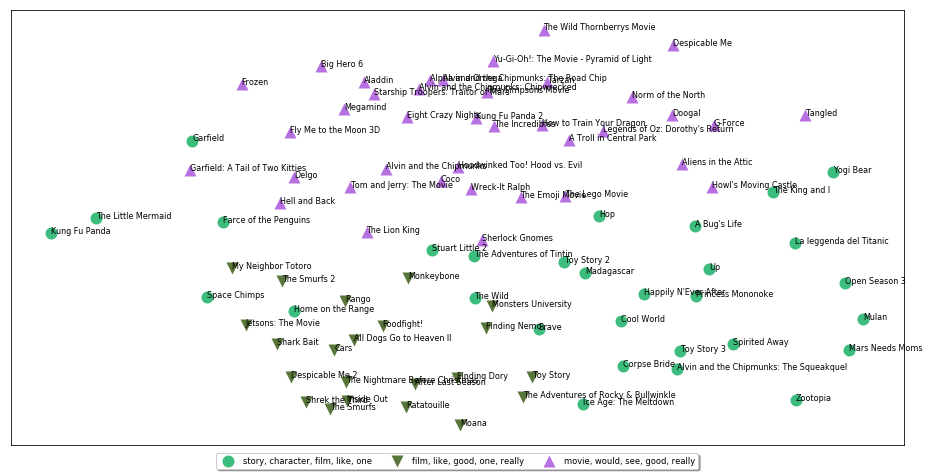

In [24]:
# visualize the clusters
plot_clusters(num_clusters=num_clusters, feature_matrix=feature_matrix,
              cluster_data=cluster_data, movie_data=reviewdf, plot_size=(16,8))

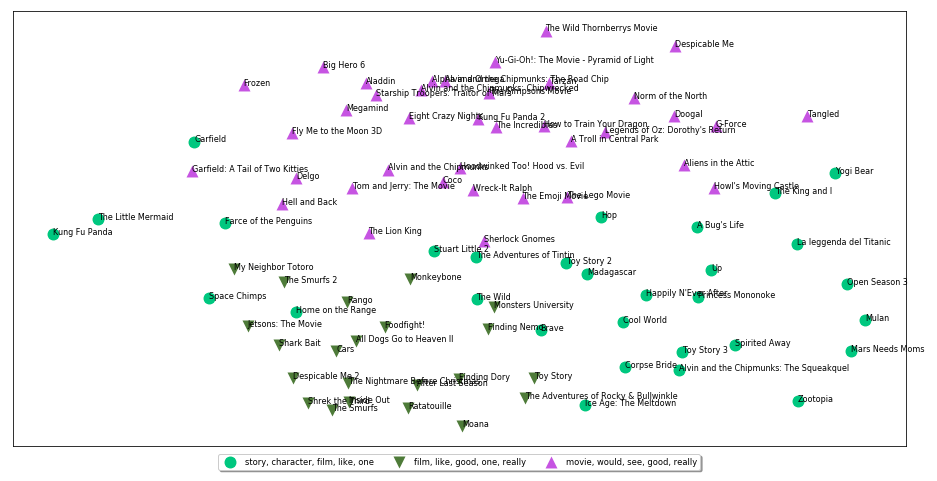

In [25]:
# Show output from when I ran it (image will be slightly different each time you run this due to random seed for clusters)
from IPython.display import Image
Image(filename='KMeans.png')

The clusters do not seem to have distinct patterns based on the sentiment scores obtained from each. Each cluster has positive and negative scores along with similar mean and median scores. It appears as though the reviews are not clustering based on words that have strong sentiment meanings.

3.	For extra credit, analyze sentiment of chunks as follows:  
    a.	Take the chunks from homework 5, and in Python, run each chunk individually through your sentiment analyzer that you used in question 1. If the chunk registers a nonneutral sentiment, save it in a tabular format (the chunk, the sentiment score).  

In [26]:
# Adapted from Sarkar pg. 356
def chunk_sentiment_analysis(review, verbose=False):
    # Reviews have already been normalized & tokenized
    tagged_text = nltk.pos_tag(review)
    pos_score = neg_score = token_count = obj_score = 0
    # Get wordnet synsets based on POS tags
    # Get sentiment scores if synsets are found
    for word, tag in tagged_text:
        ss_set = None
        if 'NN' in tag and swn.senti_synsets(word, 'n'):
            ss_set = swn.senti_synsets(word, 'n')[0]
        elif 'VB' in tag and swn.senti_synsets(word, 'v'):
            ss_set = swn.senti_synsets(word, 'v')[0]
        elif 'JJ' in tag and swn.senti_synsets(word, 'a'):
            ss_set = swn.senti_synsets(word, 'a')[0]
        elif 'RB' in tag and swn.senti_synsets(word, 'r'):
            ss_set = swn.senti_synsets(word, 'r')[0]
        # if senti-synset is found
        if ss_set:
            # add scores for all found synsets
            pos_score += ss_set.pos_score()
            neg_score += ss_set.neg_score()
            obj_score += ss_set.obj_score()
            token_count += 1
        else:
            token_count = 1
    # aggregate final scores
    final_score = pos_score - neg_score
    norm_final_score = round(float(final_score) / token_count, 2)
    final_sentiment = 'positive' if norm_final_score >= 0 else 'negative'
    if verbose:
        norm_obj_score = round(float(obj_score) / token_count, 2)
        norm_pos_score = round(float(pos_score) / token_count, 2)
        norm_neg_score = round(float(neg_score) / token_count, 2)
        # to display results in a nice table
        sentiment_frame = pd.DataFrame([[final_sentiment, norm_obj_score,
                                         norm_pos_score, norm_neg_score, norm_final_score]],
                                       columns=pd.MultiIndex(levels =[['SENTIMENT STATS:'],
                                                                      ['Predicted Sentiment', 
                                                                       'Objectivity','Positive',
                                                                       'Negative', 'Overall']],
                                                             labels=[[0,0,0,0,0],[0,1,2,3,4]]))
        print sentiment_frame
    return float(norm_final_score)

In [27]:
# NOTE/WARNING: this cell takes a while to run since it has to loop through every POS phrase
chunks = []
sentscore = []
sep = '/'
for review in reviews:
    review = review.encode('ascii', 'ignore').decode('ascii')
    tree = parsetree(review)
    for sentence_tree in tree:
        chunk = sentence_tree.chunks
        for word in chunk:
            word = word_tokenize(str(word))
            chunk_list = []
            for token in word:
                word = token.split(sep, 1)[0]
                word = no_punc(word)
                if word != 'Chunk' and word != '':
                    chunk_list.append(word)
            if chunk_list != []:
                print chunk_list
                print chunk_sentiment_analysis(chunk_list, verbose=True)
                if chunk_sentiment_analysis(chunk_list, verbose=False) != 0:
                    chunks.append(chunk_list)
                    sentscore.append(chunk_sentiment_analysis(chunk_list, verbose=False))

['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['have', 'enjoyed']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.69     0.31      0.0    0.31
0.31
['most']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'computeranimated', 'films']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0


     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Finding']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['Nemo']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['as']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['when']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'flock']
     SENTIMENT STATS:       

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.31      0.0     0.19   -0.19
-0.19
['speak']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['with']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['an', 'Australian', 'accent']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['In']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'scene']
     S

['picture']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['Most']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'humor']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['is', 'based']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.13     0.06    0.06
0.06
['on']
     SENTIM

['as']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['they']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['re', 'forced']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.19     0.06    0.13
0.13
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['journey']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['through']
     SENTIMENT 

['the', 'only', 'Pixar', 'film']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['feature']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['true', 'character', 'development']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.71     0.17     0.13    0.04
0.04
['In']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0     

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.63     0.13     0.25   -0.13
-0.13
['got', 'ta']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.94     0.06      0.0    0.06
0.06
['eat']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['s']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['perhaps']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['the', 'film']
     SENTIMENT STATS:

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.94      0.0     0.06   -0.06
-0.06
['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['am']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['first']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['foremost']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'story', 'guy']
     SENTIMENT STAT

['frightening']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.38      0.0    0.38
0.38
['at']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['times']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.5      0.0     0.5
0.5
['Still']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.88      0.0     0.13   -0.13
-0.13
['key']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STAT

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['never', 'goes']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.69      0.0     0.31   -0.31
-0.31
['overboard']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['quite', 'often', 'absolutely', 'perfect']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.53     0.28     0.19    0.0

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['by']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['formulaic', 'kiddiefare']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Unlike']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['most']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['films']
     SENTIMENT 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['The', 'film']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['also', 'teaches']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['some', 'good', 'lessons']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.42     0.25      0.0    0.25
0.25
['for']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the',

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['detail']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['more', 'so']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['that']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['their', 'creative', 'teams']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['have', 'alwa

0            positive         1.0      0.0      0.0     0.0
0.0
['has']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['various', 'elements']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.56     0.06     0.38   -0.31
-0.31
['from']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['actionadventure']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['comedy']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0    

0            positive         1.0      0.0      0.0     0.0
0.0
['old']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.38      0.0    0.38
0.38
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['obsess']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['with']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['thought']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.8

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['come']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['terms']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['with']
     SENTIMENT STATS:                

['belonging']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.5      0.0     0.5
0.5
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'new', 'human', 'character']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.66     0.09      0.0    0.09
0.09
['called']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['Bonnie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0


     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.38      0.0     0.63   -0.63
-0.63
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['suffer']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'heartbreak']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.19      0.0     0.31   -0.31
-0.31
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['be', 'left']
     SENTIMENT S

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.88      0.0     0.13   -0.13
-0.13
['can', 'someone']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['turn']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['into']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'bitter', 'soul']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.42     0.17     0.08    0.08
0.08
['allowed']
    

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['least']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['two', 'scenes']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['got']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['me']
     SENTIMENT STATS:        

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['thought']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['was', 'pitch']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.13     0.06    0.06
0.06
['perfect']
     SENTIMENT STATS:   

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['centerstage']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['As']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['with']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['all', 'PIxar', 'feature', 'films']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['a', 'shor

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['positive', 'and']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.38     0.63      0.0    0.63
0.63
['constructive', 'message']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['It']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['made']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['me']
     SE

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['with']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['uninspired']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.13     0.38      0.5   -0.13
-0.13
['Shark', 'Tale']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['Pixar']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['contains']
     SENTIMEN

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['other']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.38      0.0     0.63   -0.63
-0.63
['movies']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['It']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['s']
     SENTIMENT STATS:                

0            positive         0.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['be']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['a', 'surprisingly', 'good', 'action', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.17      0.0    0.17
0.17
['The', 'plentiful', 'action', 'sequences']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.69      0.0     0.06   -0.06
-0.06
['are']
     SENTIMENT STATS:                                      
  Predicted Sentiment

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['makes']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['the', 'less', 'talented', 'ones']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.13      0.0    0.13
0.13
['feel']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['bad', 'The', '

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.88      0.0     0.13   -0.13
-0.13
['very', 'profound', 'truth']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.42      0.5     0.08    0.42
0.42
['The', 'voice', 'actors']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['are']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['so', 'great']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['when', 'actually', 'not']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.33     0.13     0.21   -0.08
-0.08
['all', 'of', 'them']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['can']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['offers']
  

['very', 'common']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.13     0.13     0.0
0.0
['throughout']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'Pixar', 'films']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['they']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['present', 'it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Studio', 'Ghibli']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['This', 'multiple', 'awardwinning', 'masterpiece']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.94     0.06      0.0    0.06
0.06
['has', 'grown']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13    

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'most', 'lavish', 'animation']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75      0.0      0.0     0.0
0.0
['ever']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['hit']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['the', 'screenTh

['like']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Lewis', 'Carroll']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['Alice', 'In', 'Wonderland', 'and', 'The', 'Neverending', 'Story']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.94     0.06      0.0    0.06
0.06
['have']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['we']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive       

['from']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'basic', 'storyline']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'omnipresent', 'universal', 'themes']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.63      0.0     0.04   -0.04
-0.04
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['seem']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['understand']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['where']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['I']
     SENTIMENT STATS:            

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['realise']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['message']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['the', 'film']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['is', 'trying']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.13     0.06    0.06
0.06
['to']
     SENTIMENT 

['does']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['brilliantly']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5     0.38     0.13    0.25
0.25
['through']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'message', 'I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['took']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['away']


     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['this', 'film']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['equal', 'parts']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.94     0.06      0.0    0.06
0.06
['sad']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['equal', 'parts']
     SEN

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative         0.5      0.0      0.5    -0.5
-0.5
['the', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['In']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Summer']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['song']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['with']
     SENTIMENT STATS:     

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['not']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.38      0.0     0.63   -0.63
-0.63
['a', 'real', 'story']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['It']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['s']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['a', 'cartoon']
     SENTIMENT ST

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'past', 'several', 'years', 'we']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        2.25      0.0     0.75   -0.75
-0.75
['ve', 'received']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['filmmaker']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['poor', 'attempts']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative         0.5     0.06    

['an', 'old', 'cartoon']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.54     0.13      0.0    0.13
0.13
['about']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'man']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['filtered']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['with']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['countle

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['our', 'attention']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'original', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['released']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['in']
   

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['rescue']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['attempts']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['save']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.5      0.0     0.5
0.5
['Woody']
     SENTIMENT STATS:        

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.88      0.0     0.13   -0.13
-0.13
['logical', 'explanation']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.69     0.31      0.0    0.31
0.31
['would', 'bore']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.44     0.06      0.0    0.06
0.06
['the', 'majority']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['an

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.31     0.19      0.0    0.19
0.19
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['original']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['Toy', 'Story']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['This', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['is']
     SENTIMENT ST

['very', 'interesting']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.56     0.31     0.13    0.19
0.19
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['keep']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['you']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['engrossed']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['throughout']
  

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.79     0.04     0.17   -0.13
-0.13
['a', 'sweet']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['clumsy', 'Panda']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.81     0.06     0.13   -0.06
-0.06
['has']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['dreams']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['of']
     SENTIMENT

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         2.0      0.0      0.0     0.0
0.0
['Po', 'accidentally']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.94     0.06      0.0    0.06
0.06
['enters']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'contest']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.38     0.13      0.0    0.13
0.13
['is', 'named']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.69     0.25     0.06    0.19
0.19
['the', 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['voices']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['were']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['just']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['right']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['for']
     SENTIMENT STATS:           

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['10', 'and', 'daughter']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['aged']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['was']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['my', 'son']
     SENTIMEN

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['tears']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['do']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['nt', 'usually']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['cry']
     SENTIMENT STATS:          

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.19      0.0    0.19
0.19
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['has']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['no', 'connection']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.44      0.0     0.06   -0.06
-0.06
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Disney']
     SENTIMENT STATS: 

['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['am']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['not', 'sure']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.31     0.13     0.56   -0.44
-0.44
['how']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'teenager']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['would', 'respond']
 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['would', 'recommend']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.44      0.0     0.06   -0.06
-0.06
['you']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['do', 'nt', 'watch']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.96     0.04      0.0    0.04
0.04
['the', 'trailer']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['jus

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.88      0.0     0.13   -0.13
-0.13
['a', 'great', 'film']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['The', 'story', 'line']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['was']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['also', 'very', 'easy']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.54     0.29     0.17    0.13


     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['an', 'iota']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.44     0.06      0.0    0.06
0.06
['of', 'intelligence']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.25     0.25      0.0    0.25
0.25
['will', 'tell']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['you']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['that']
     S

['the', 'tale']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['We']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['live']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'society']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['with']
     SENTIMENT 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['the', 'brunt']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.44      0.0     0.06   -0.06
-0.06
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['their', 'decisions']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['We']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['live']
     SENTIMENT 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['without']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['stories', 'that', 'date', 'thousands']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.96     0.04      0.0    0.04
0.04
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['years']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['caution

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['People']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['other', 'countries', 'hundreds']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.79      0.0     0.21   -0.21
-0.21
['upon']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['hundreds']
   

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['about']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'motherdaughter', 'story']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['has']
     SENTIMENT

['sheer', 'lovely', 'heart']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.44      0.0     0.06   -0.06
-0.06
['is', 'considered']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.19     0.06    0.13
0.13
['cheesy']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['while']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['on', 'the', 'other', 'hand']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.29     0

['should', 'dare', 'question']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.54     0.04     0.08   -0.04
-0.04
['that']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['putting']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['a', 'real', 'message']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.75      0.0     0.25   -0.25
-0.25
['Let']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['me']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['start']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['by']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['saying']
     SENTIMENT STATS:              

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['just']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['that']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['m', 'obviously', 'going']
     SENTIMENT STATS:

['you']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['need']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.13     0.13     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['be']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['a', 'video', 'game', 'fan']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['to']
     SENTIM

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.5      0.0     0.5
0.5
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['of', 'the', 'Pixar']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['even', 'greatly', 'enjoyed']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.79     0.21      0.0    0.21
0.21
['the', 'animated', 'short']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.04      0.0  

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['was', 'blown']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.63     0.13     0.25   -0.13
-0.13
['away']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['My', 'wife']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['not']
     SENTIMENT STATS:

0            positive        0.63     0.25     0.13    0.13
0.13
['toldIf', 'you']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['played']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['arcades']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.75      0.0     0.25   -0.25
-0.25
['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.42     0.17     0.08    0.08
0.08
['with']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['great', 'characters']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['masterfully']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['recommended']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.88      0.0     0.13   -0.13
-0.13
['out']
   

['makes']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['a', 'good', 'story']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.42     0.25      0.0    0.25
0.25
['the', 'thing']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['that']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'sto

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['like']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'large', 'introduction']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.54     0.08     0.04    0.04
0.04
['that']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['never', 'really', 'g

['is', 'plenty']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['of', 'light', 'humor']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.58      0.0     0.08   -0.08
-0.08
['especially']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['with']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'penguins']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0    

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['me']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['The', 'story']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['was', 'handled']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.13     0.06    0.06
0.06
['too', 'weakly']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.44     0.25     0.31   -0.06
-0.06
['This', 'movie'

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['Nemo']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['have']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['admit']
     SENTIMENT STATS:                 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['his', 'final', 'race']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.04      0.0    0.04
0.04
['Chick', 'Hicks']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.56     0.06     0.38   -0.31
-0.31
['Michael', 'Keaton']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['thus']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['

['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['firstrate']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['It']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['s']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['that', 'sort']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['of', 'greatness']
     SEN

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['brings']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['some', 'of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'essential', 'charm']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.46     0.21      0.0    0.21
0.21
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['this', 'film'

['how']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['is', 'told']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.13     0.06    0.06
0.06
['very']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5     0.25     0.25     0.0
0.0
['essence']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['of', 'cinema']
     SENTI

['being']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['irritatingly', 'so']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.19      0.0    0.19
0.19
['You']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['ca', 'nt', 'help']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.25     0.25      0.0    0.25
0.25
['care']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['abou

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.31     0.13     0.06    0.06
0.06
['beside']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Cars']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:       

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'theaters']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['From']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'first', 'few', 'scenes', 'I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         3.0      0.0      0.0     0.0
0.0
['was

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative         0.5      0.0     0.17   -0.17
-0.17
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Robin', 'Williams', 'and', 'his']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         2.0      0.0      0.0     0.0
0.0
['own', 'talent']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.13     0.06    0.06
0.06
['for', 'mimmicry']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0


     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['see']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['such', 'great', 'character']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.96      0.0     0.04   -0.04
-0.04
['though']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['are']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['so', 'many', 'it'

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['out']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['ideals', 'I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['felt', 'would', 'make']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['their', 'way']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['into']
    

['be']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['a', 'laugh']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['started']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['out']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['well', 'enough']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['with']
     SEN

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['was']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['a', 'big', 'letdown']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.29     0.08     0.29   -0.21
-0.21
['Weak', 'humor']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['a', 'mediocre', 'plot']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
[

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['their', 'personalities']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.44      0.0     0.06   -0.06
-0.06
['Wait']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['for']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'DVD', 'Id']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['sayA', 'fan

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['reflective']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'past', 'few', 'seasons']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.69      0.0     0.06   -0.06
-0.06
['if']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['you']
     S

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'settlement']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['humans', 'and', 'the', 'coming']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['of', 'metalworking']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.19     0.38     0.44   -0.06
-0.06
['in', 'everyone']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['no', 'easy', 'balance']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.38     0.21     0.08    0.13
0.13
['The', 'Princess']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['Hime']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['o

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['Sen']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Chihiro']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['more', 'nature']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['more', 'wild']
     SENTIMENT S

['documented']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['a', 'lot']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'production']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['The', 'English', 'translation']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['no', 'other', 'animation']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.46      0.0     0.21   -0.21
-0.21
['like']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STA

['the', 'naysayers']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.38      0.0     0.13   -0.13
-0.13
['prior']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['this', 'films']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['release']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['before'

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['will', 'be']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.31     0.13     0.06    0.06
0.06
['flabbergasted']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.63      0.0     0.38   -0.38
-0.38
['by']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['how']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['amazing', 'it']
     SENTIM

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.25      0.0     0.25   -0.25
-0.25
['Harry', 'Potter']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['the', 'Goblet']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['of', 'fire']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['got']
     SENTI

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['So']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['best']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.25     0.75      0.0    0.75
0.75
['not']
     SENTIMENT STATS:                   

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.19     0.06    0.13
0.13
['that', 'add']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['this', 'pretty', 'great', 'emotional', 'mix']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.66     0.09      0.0    0.09
0.09
['a', 'college', 'comedy']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0  

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['makes']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['up']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['for', 'it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['All', 'in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['all', 'a', 'good', 'effort']
    

['as']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'family']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['a', 'group']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['friends']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['individually']
     

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['above']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Miyazaki', 'standardsThe', 'characters']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['are']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['wonderful']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['wi

['Laputa', 'Castle']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'Sky']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['you']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['can', 'not', 'miss']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.38      0.0     0.29   -0.29
-0.29
['it

['groundbreaking']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['stopmotion', 'animation', 'film']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['Burton', 'all', 'the', 'way']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['as']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Jack', 'SkellingtonBut', 'Jack']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.13     0.13     0.0
0.0
['quickly', 'growing', 'tired']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'same', 'old', 'routine', 'year']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive       

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.38      0.0    0.38
0.38
['by']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Christmas']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['as']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['he']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                

0            positive         0.5     0.25     0.25     0.0
0.0
['after']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'other']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.19      0.0     0.31   -0.31
-0.31
['especially']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['with']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['first']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            posi

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['contains']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['little', 'more', 'thematic']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.88      0.0     0.13   -0.13
-0.13
['finds']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.38     0.63      0.0    0.63
0.63
['himself']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['inheriti

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['a', 'different', 'spin']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.46     0.21      0.0    0.21
0.21
['on']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['The', 'lesson']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['learned', 'here', 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['like']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'favorite', 'candy', 'bar']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.72     0.03      0.0    0.03
0.03
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['s']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['chockfull']
     SEN

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['great', 'voice', 'work']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['the', 'animation']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['both', 'the', 'motion']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.38     0.13      0.5   -0.38
-0.38
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['felt']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['more']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['like']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['fairy', 'tales']
     SENTIMENT STATS:    

0            positive         0.5      0.0      0.0     0.0
0.0
['their']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['newest', 'feature', 'film']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['Coco']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['finally', 'made']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['me']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0  

['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['hope']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['comfort']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative         0.5      0.0      0.5    -0.5
-0.5
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['a', 'great', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['Definitely']
    

['I', 'first']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['watched']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['this', 'film']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Japanese']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['with']
     S

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'Disney', 'formula']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['always', 'involves']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['a', 'villain']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.31      0.0     0.19   -0.19
-0.19
['being', 'trashed']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.19     0.06 

['a', 'good', 'time']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.42     0.25      0.0    0.25
0.25
['gives']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.88      0.0     0.13   -0.13
-0.13
['us']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['hope']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['that']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['is']
     SENTIME

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['momentsIn', 'addition']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'principals']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['the', 'possums']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['the'

['Toy', 'Story', '2', 'kind']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.5      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['animated', 'sequel']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.94     0.06      0.0    0.06
0.06
['a', 'genuine', 'good', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.31     0.28     0.16    0.12
0.12
['takes']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0     

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Po']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['learns']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['that']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['he']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['is', 'adopted']
     SENTIMENT STATS:       

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['children']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['did', 'nt', 'go']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['the', 'route']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['of']
     SENTIMEN

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.25     0.56     0.19    0.38
0.38
['kindness']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0     0.63     0.38    0.25
0.25
['Johnny', 'Depp']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['a', 'perfect', 'Victor', 'Van', 'Dort']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         2.0     0.88     0.13    0.75


     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['well']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.38      0.0    0.38
0.38
['Hope', 'you']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['enjoy']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'film']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['as']
     SENTIMENT STATS

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['her']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'ancient', 'elders']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['her', 'family', 'ask', 'the', 'great', 'Stone', 'Dragon']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        1.25      0

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.69     0.03     0.03     0.0
0.0
['gets', 'lost']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.69     0.06     0.25   -0.19
-0.19
['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'middle']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'Mojave', 'Desert']
 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['by']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Gore', 'Verbinski']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['garners']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['enthusiastic', 'and']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.38     0.63      0.0    0.63
0.63
['terrific', '

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['also', 'loved']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['visual', 'references']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['characters']
     SEN

['music', 'score']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.06     0.06     0.0
0.0
['pays']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['delightful', 'homage']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.38     0.63      0.0    0.63
0.63
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'scores']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.38      0.0     0.13   -0.13
-0.13

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['kids']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['heads']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['s']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['exactly', 'why']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['I']
     SENTIMENT STATS:        

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.31     0.13     0.06    0.06
0.06
['an', 'instant', 'cult']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['classic']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.38      0.5     0.13    0.38
0.38
['is', 'going']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.13     0.06    0.06
0.06
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['go']
     SENT

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['too']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.63     0.13     0.25   -0.13
-0.13
['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['think']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['the', 'writers']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['did']
     SENTIMENT STATS:      

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['the', 'speaking', 'voice']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.04      0.0    0.04
0.04
['should', 'also', 'provide']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['the', 'singing', 'voice']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['She']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      

['so', 'insufferable']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.19      0.0    0.19
0.19
['Obviously']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.5      0.0     0.5
0.5
['ending', 'had']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['be', 'found']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.13     0.06    0.06
0.06

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['they']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['really', 'believe']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.38      0.0    0.38
0.38
['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['they']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['re', 'doing']
     SENTIMENT S

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Finding']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['DoryThe', 'other', 'problem']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.25      0.0     0.42   -0.42
-0.42
['with']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['creating']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['spinoff', 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['his', 'father', 'Marlon', 'and', 'his', 'sidekick', 'Dory']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.96     0.04      0.0    0.04
0.04
['on']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'quest']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0 

['a', 'few', 'quirky', 'friends']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.59     0.03     0.13   -0.09
-0.09
['along']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'way']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['felt']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['li

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['from']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Australia']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'United', 'States']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['then', 'lingered']
 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.56     0.19      0.0    0.19
0.19
['that', 'come']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['out']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['nowadays']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['It']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['s']
     SENTIMENT STATS:       

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['best']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.25     0.75      0.0    0.75
0.75
['Music']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['for']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'movie', 'I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['felt', 'was']
     SENTIMENT

['Since']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Spielberg']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['has', 'become']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['an', 'avid', 'fan']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['gorgeo

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['adventures']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['One', 'day']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['he']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['found']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['a', 'model']
     SENTIMENT ST

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['It']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['s']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['not']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.38      0.0     0.63   -0.63
-0.63
['right']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                   

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['a', 'little', 'imagination']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.42      0.0     0.25   -0.25
-0.25
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['ingenious']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.38     0.63      0.0    0.63
0.63
['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['shifting']
    

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5     0.44     0.06    0.38
0.38
['breathtaking', 'animation']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['equals']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['up']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['amazing']
     SENTIME

['out']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Thanks']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['reading']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['my', 'review']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.44     0.06      0.0    0.06
0.06
['on']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['The', 'Adventures']
 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['entertaining']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['surely', 'ideal']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.5      0.0     0.5
0.5
['for']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['young', 'children']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['Unfairly',

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['well', 'acted']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.19      0.0    0.19
0.19
['well', 'animated']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['Breckin', 'Meyer']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['plays']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['the', 

0            positive         1.0      0.0      0.0     0.0
0.0
['has']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['an', 'agreement']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['with']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'mice']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['gets']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            posi

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['off']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['into', 'the', 'city']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['become']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'Christmas', 'tree']
   

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['with']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Dave']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['becoming']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['like']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'Dad']
     SENTIMENT STATS:      

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['hear']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['them']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['You']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['recognize']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['their', 'sound']
     SENTIMENT STATS:

['Run', 'Time']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['Rated']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.63     0.13     0.25   -0.13
-0.13
['PG']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['You']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['look']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['at']
     SENTIMENT STATS:

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['weird']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['let']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['start']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['from']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'obvious']
     SENTIMENT STATS:  

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['all', 'that', 'I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['have', 'said']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['together']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['you']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['can', 'assume']
   

['with']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'bit']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.44      0.0     0.06   -0.06
-0.06
['of', 'imagination', 'Stuart']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.54      0.0     0.13   -0.13
-0.13
['Margalo']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['opened']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0

['into']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['my', 'head']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['exactly', 'is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.19     0.06    0.13
0.13
['Stuart']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['s']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['his', 'history']
 

['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'first', 'film']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['here']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['he']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['flies']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['like']
     SENTIMEN

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['that', 'kind']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['of', 'inspiration']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.44     0.06      0.0    0.06
0.06
['so', 'believe']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.94     0.06      0.0    0.06
0.06
['me']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['when']
     

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['might', 'even', 'explain']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.54     0.13      0.0    0.13
0.13
['a', 'lot']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['things']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['Master', 'White']

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['a', 'current', 'rating']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['loved']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.5      0.0     0.5
0.5
['it']
     SENTIMENT STATS: 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.42     0.25      0.0    0.25
0.25
['on']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'lazy', 'afternoon']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['for']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'kids']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['out']
     SENTIMEN

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['when']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['my', 'mother']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['decided']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['buy']
     SENTIMENT STATS:      

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['talent']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['Then']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['s']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['a', 'plot']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['where']
     SENTIMENT STATS:        

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['about']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['real']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['as']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['an', 'episode']
     SENTIMENT STATS:       

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['does', 'nt', 'mean']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['you']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['have']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['reach']
     SENTIMENT STATS: 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.19      0.0    0.19
0.19
['excellent', 'quality']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.31     0.69      0.0    0.69
0.69
['let']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['face', 'it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['by']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['being', 'designed']
 

['acting', 'ability']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['Anyway']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['Bob', 'Hoskins']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['a', 'hoot']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['as'

['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['m', 'really', 'puzzled']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67     0.25     0.08    0.17
0.17
['by']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['these', 'reviews']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.44     0.06      0.0    0.06
0.06
['Firstly']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['we'

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['that']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['awful', 'song']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['from']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', '70s']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['I']
     SENTIMENT STATS:  

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['actually', 'enjoyed']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.38      0.0    0.38
0.38
['s']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['no', 'point', 'me']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['regurgitating']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['the', '

['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['like']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['for', 'you']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['This', 'time']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['the', 'phrase']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['From']
     

['vivacious', 'music']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.69     0.31      0.0    0.31
0.31
['might', 'fool']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.44     0.06      0.0    0.06
0.06
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['some', 'kids']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['make

['seriously']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['thinking']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['about']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['better']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.13     0.88      0.0    0.88
0.88
['I']
     SENTIMENT ST

['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'old', 'clich']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.38      0.0    0.38
0.38
['son']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['refuses']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['follow']
     SENTI

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['just']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['because']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['actually']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.38      0.0    0.38
0.38
['like']
     SENTIMENT STATS:         

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['away']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['they']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['really', 'blew']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5     0.31     0.19    0.13
0.13
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['she']
     SENTIMENT STATS:      

['was']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['so']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['out']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['of', 'place']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['especially']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['with']
     SENTIMENT S

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'wilds']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.38      0.0     0.13   -0.13
-0.13
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Africa']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['However']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.38     0.13      0.5   -0.38
-0.38
['it']
     SENTIMENT STATS: 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.31     0.19      0.0    0.19
0.19
['were']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['excellent']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'characters']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['mostly', 'funny']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['the', 'ani

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.75     0.04     0.21   -0.17
-0.17
['on']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['serious']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['serious']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['the', 'last', 'third']
     SENTIMEN

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['a', 'big', 'fan']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.54     0.08     0.04    0.04
0.04
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Adam', 'Sandler', 'and', 'I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['love']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.38     0.63      0.0    0.63
0.63
['all', '

0            positive         1.0      0.0      0.0     0.0
0.0
['for']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['agesMy', 'favorite', 'character']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.04      0.0    0.04
0.04
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['Whitey']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.75      0.0     0.25   -0.25
-0.25
['His', 'voice']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overa

['that']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'boy', 'Milo']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.54     0.08     0.04    0.04
0.04
['is', 'raised']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.13     0.06    0.06
0.06
['by']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['his', 'Mon']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['with'

['Mon']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['bring']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['her']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['back']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Earth']
     SENTIMENT STATS:       

['took']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['my']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['year']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['old', 'grandsons']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.19      0.0    0.19
0.19
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['see']
     SENTIMENT STA

['have', 'ever', 'seen']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.92     0.08      0.0    0.08
0.08
['Obvious']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.5      0.0     0.5
0.5
['enjoyable']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.25      0.5     0.25    0.25
0.25
['for']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'little', 'ones']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.54      0.0     0.13   -0.

0            positive         0.0      0.0      0.0     0.0
0.0
['for', 'something']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['do']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['this', 'summer', 'you']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['should', 'not', 'feel']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative O

['did']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['his', 'usual', 'command']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.04      0.0    0.04
0.04
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'medium', 'slide']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['down', 'so', 'much']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.96      0.0     0.0

['than']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['you']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['have', 'is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.13     0.06    0.06
0.06
['a', 'sad']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['cynical', 'exercise']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.69      0.0     0.31   -0.31
-0.31
['to']
 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['not']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.38      0.0     0.63   -0.63
-0.63
['add']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['next']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['nothing']
     SENTIMENT STATS:            

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.75      0.0     0.25   -0.25
-0.25
['allowing']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['a', 'product']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['so', 'obviously', 'unfinished']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.63     0.17     0.21   -0.04
-0.04
['as']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['to'

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['only']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['something']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['else']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['as']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['interesting']
     SENTIMENT STATS:    

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'days']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Yogi', 'Bear']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['I']
     SENTIMENT STATS:      

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['into']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['this', 'film']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['with']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'good', 'attitude']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.42     0.25      0.0    0.25
0.25
['I']
     SENTIME

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.94     0.06      0.0    0.06
0.06
['from']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'attitude']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['that']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['a', 'cartoon']
     SENTIMENT S

['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Rocky', 'Bullwinkle']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['out']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['It']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['has', 'been']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.69     0.25     0.06    0.19
0.19
['nearly']
     S

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['saw']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['mentioned']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['in']
     SENTIMENT STATS:                 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['decide']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['set', 'out']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['try']
     SENTIMENT STATS:           

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['have']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['agree']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['wholeheartedly']
     SENTIMENT STATS:      

['they']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['are']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['very', 'minor', 'characters']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.54     0.17     0.29   -0.13
-0.13
['Not', 'only', 'is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.67     0.08     0.25   -0.17
-0.17
['the', 'plot']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['were', 'made']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.13     0.06    0.06
0.06
['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'franchise']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['so']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['it']
     SENTIMENT STATS

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['be']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['very', 'unmemorable']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative         0.5     0.13     0.38   -0.25
-0.25
['Henry', 'Selick']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['first', 'feature']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['The

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Selick']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['has', 'watered']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['the', 'original', 'batch']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Nightmare',

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['believe']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['the', 'film']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['has']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['its', 'flaws']
     SENTIMENT STA

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.06     0.31     0.13    0.19
0.19
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'new', 'actor']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.54     0.13      0.0    0.13
0.13
['without']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['giving']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.88      0.0     0.13   -0.13
-0.13
['matter']
     SENTIM

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['was', 'realised']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.13     0.06    0.06
0.06
['through']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['an', 'illchosen', 'mixture']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.44      0.0     0.06   -0.06
-0.06
['of', 'costume']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0


     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['are']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['actually', 'funny']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.56     0.44      0.0    0.44
0.44
['s']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['because']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['they']
     SENTIMENT STATS:

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['can', 'not', 'believe']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.42     0.04     0.21   -0.17
-0.17
['how']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['this', 'great', 'family', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75      0.0      0.0     0.0
0.0
['is', 'so', 'underrated']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        1.63     0.25  

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75      0.0      0.0     0.0
0.0
['In']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'USA', 'it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['a', 'new', 'entry']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.54     0.13      0.0    0.13
0.13
['at', 'number']
    

['kept']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['your', 'interest']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['throughout']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'whole', 'entire', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.72     0.03      0.0    0.03
0.03
['Too', 'many', 'people']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.88   

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.38     0.63      0.0    0.63
0.63
['touch']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['your', 'heartThe', 'humor']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['great']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['I']
     SENTIMENT 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['back']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['my', 'seat']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['because']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['an', 'object']
     SENTIMENT STATS

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['this', 'movie', 'today']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.04      0.0    0.04
0.04
['the', 'German', 'version']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['honestly']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.38      0.0    0.38
0.38
['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['for']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['kids']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['for']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['grownups']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:              

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['a', 'lot']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['of', 'nonsense']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'books']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['too']
     SENTIMENT 

['Today', 'I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['watched']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['the', 'sequel']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['this', 'cute', 'spin']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
[

['thrilling']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['funny', 'scene']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['the', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['takes']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['a', 'quick', 'turn']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0


['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['this', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['As']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['a', 'result']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['this', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['really', 'ha

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['assure']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['you']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['that']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['kids']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['will', 'love']
     SENTIMENT STATS:     

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.54     0.08     0.04    0.04
0.04
['good']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.25     0.75      0.0    0.75
0.75
['about']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['this', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['that']
     SENTIMENT STATS:   

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['may', 'not', 'enjoy']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.33     0.13     0.21   -0.08
-0.08
['this', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['as']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['much']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['as']
     SENTIMEN

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['was']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['not']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.38      0.0     0.63   -0.63
-0.63
['a', 'masterpiece']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.44     0.06      0.0    0.06
0.06
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['still', 'was']
     SENTIMENT 

['by']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['this', 'film']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['as']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['others']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Overall']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['for']
     SENTIMENT STA

['Have']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['you']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['seen']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['movies']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['that']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['almost', 'wore']
     SENTIMENT

['five', 'or', 'tenyearolds']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['want', 'but', 'I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.75      0.0     0.25   -0.25
-0.25
['m', 'not', 'surprised']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.75     0.04     0.21   -0.17
-0.17
['this', 'animated', 'film']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.04      0.0    0.04
0.04
['was']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive    

['heroes']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.38      0.5     0.13    0.38
0.38
['the', 'space', 'chimps']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['were']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['always']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['bickering']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.75      0.0     0.25   -0.25
-0.25
['am

['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['looked']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['forward']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['this', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['having', 'been', 'pleas

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['respectively']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['she']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['learns']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['that', 'everyone']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['fate']
     SENTIMENT

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['leads']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['other']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.38      0.0     0.63   -0.63
-0.63
['interesting', 'notions']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.19      0.0    0.19
0.19
['such']
     SENTIMEN

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['getting']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['the', 'great', 'lines']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['Dick']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['does', 'get']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.94     0.06      0.0    0.06
0.06
['some', 'good'

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['ve', 'always', 'liked']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.04      0.0    0.04
0.04
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['quite']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.38      0.0     0.63   -0.63
-0.63
['fun']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.38      0.0    0.38
0.38
['here']
     SENTIMENT 

['embarrassingly', 'overdone']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.63      0.0     0.38   -0.38
-0.38
['In', 'conclusion']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['not', 'recommended']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.63      0.0     0.38   -0.38
-0.38
['at']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['sadly']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.38      0.0     0

['the', 'house']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['trying']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['catch']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative         0.5      0.0      0.5    -0.5
-0.5
['jerry']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['Maybe']
     SENTIMENT

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         2.0      0.0      0.0     0.0
0.0
['were']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['use']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['seeing', 'chase']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['each', 'other']
     SENTIMENT ST

['his']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['The', 'North']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['totally', 'funny']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.5      0.0     0.5
0.5
['with']
     SENTI

['You']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['know']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['this', 'review']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.44     0.06      0.0    0.06
0.06
['is', 'nt', 'based']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.08     0.04    0.04
0.04
['on']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'prem

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['faith']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['fear']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.13      0.0     0.88   -0.88
-0.88
['that']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['they', 'd', 'lose', '45', 'MILLION', 'DOLLARS']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['know']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['Charlie', 'Sheen']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['spent']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', '45', 'million', 'on', 'c

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['tears', 'of', 'joy']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['that']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['was']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['over']
     SENTIMENT STATS: 

['as']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['artform']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['even', 'when']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['think']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['the', 'film']
     SENTIM

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['The', 'other', 'problem']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.25      0.0     0.42   -0.42
-0.42
['that', 'should', 'be']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.31     0.13     0.06    0.06
0.06
['immediately']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.63      0.0     0.38   -0.38
-0.38
['clear', 'is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.56     0.38     0.06   

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['glorify']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['this', 'crock']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['sh1tOne', 'final', 'bit']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.63      0.0     0.04   -0.04
-0.04
['of']
     S

0            positive         1.0      0.0      0.0     0.0
0.0
['After']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['last', 'season']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.88      0.0     0.13   -0.13
-0.13
['funniest', 'scene']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['sorry']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['for']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0       

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         2.0      0.0      0.0     0.0
0.0
['shatter']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['s']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['true']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.13      0.5     0.38    0.13
0.13
['all', 'that']
     SENTIMENT STATS:        

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['sit']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['laughing']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['my', 'ass']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['off']
     SENTIMENT STATS:         

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['this', 'familyfriendly', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['somewhat', 'predictable']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
[

['defeat']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.75      0.0     0.25   -0.25
-0.25
['the', 'evil', 'pie', 'company']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.53      0.0     0.22   -0.22
-0.22
['called']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['Moriarty']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Jamie', 'Demetriou']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0     

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.69     0.06      0.0    0.06
0.06
['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['have', 'seen']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['almost']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['every', 'movie', 'he']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['has', 'ever', 'be

['when']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['he']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['realizes']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['that']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Watson']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['feels']
     SENTIMENT STATS:

['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['recommend']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['this', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['for']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['ages']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STA

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['It']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['s']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['a', 'darling', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['refreshing']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STAT

['the', 'worst', 'movies', 'I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative         1.0     0.25     0.75    -0.5
-0.5
['ve', 'ever', 'seen']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['at']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'theater']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['If']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0    

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.38      0.0     0.63   -0.63
-0.63
['than']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['just']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['a', 'really', 'bad', 'movieThis']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.63     0.63     0.0
0.0
['should', 'have', 'been']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.46     0.17     0.04    0.13
0

['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['straighttovideo']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['poorly', 'animated', 'cashin', 'sequels']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        1.06     0.06     0.38   -0.31
-0.31
['apparently']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.38      0.5     0.13    0.38
0.38
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['like']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['have']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['a', 'time']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['when']
     SENTIMENT STATS:         

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.69     0.25     0.06    0.19
0.19
['rather']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.5      0.5     0.0
0.0
['below', 'par']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['so']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['thought']
     SENTIMENT STATS:     

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.38      0.0     0.63   -0.63
-0.63
['the', 'idea']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.44     0.06      0.0    0.06
0.06
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['talking']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['penguins']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS: 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['jokes']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.38      0.0    0.38
0.38
['about']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['hating', 'appearing']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.63      0.0     0.38   -0.38
-0.38
['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['stock', 'footage']
    

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.25     0.75      0.0    0.75
0.75
['OK']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['The', 'rest']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['are']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['definite', 'negatives']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.38      0.0     0.13   -0.13
-0.13
['which']
     SENT

0            positive        0.88     0.13      0.0    0.13
0.13
['that']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Mr', 'Spacely']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['voice']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Mel', 'Blanc']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            posit

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.44     0.06      0.0    0.06
0.06
['watch']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['did', 'love']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['the', 'fact']
     SENTIMENT STATS:  

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'film']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['like']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Susan', 'Sarandon', 'and', 'Bob', 'OdenkirkThe', 'animation']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0

['While']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'first', 'CGI', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['managed']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['combine']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['ele

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'most', 'boring', 'villains']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.59      0.0     0.16   -0.16
-0.16
['in', 'movie', 'history']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['voice']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0


['flies']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['in']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['this', 'movie', 'look', 'nothing']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.06     0.06     0.0
0.0
['like']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['real', 'flies']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0

['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['same']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['standardThe', 'plot']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['is']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['roughly']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.25      0.5     0.25    0.25
0.25
['the', 'same']
   

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['Why', 'else']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['would']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['monkey']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.88      0.0     0.13   -0.13
-0.13
['take', 'center', 'stage']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['in']
     S

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['using']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['crayons']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['although']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['monkeys']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.88      0.0     0.13   -0.13
-0.13
['are', 'commonly', 'known']
  

['thought']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['this', 'film']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['would']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['no']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['longer']
     SENTIMENT 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.75     0.25      0.0    0.25
0.25
['Ronny']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['enjoys', 'playing']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['soccer']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['befriends']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Conners', 'and', 'Co

['Elizabeth']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['sees']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['several', 'gypsies']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.75      0.0     0.25   -0.25
-0.25
['dancing']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['at']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'dock

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['by']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['their', 'observations']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['during']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['their', 'trips']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['throughout']
  

['Mr', 'Ice', 'and', 'use', 'him']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         3.0      0.0      0.0     0.0
0.0
['for', 'causing']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['destruction']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['Conners', 'and', 'Ronny']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['introduce']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['Conners', 'and', 'Ronny']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['agree']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['help']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.5      0.0     0.5
0.5
['arrange', 'a', 'meeting'

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.31     0.19      0.0    0.19
0.19
['despite']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'fact']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['that']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['they', 'both', 'flirt']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['constantly']
 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['news']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['his', 'whaling', 'ships', 'by', 'telegraph']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.5      0.0      0.0     0.0
0.0
['the', 'mice']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
[

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['see']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['can', 'throw', 'ice']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.67      0.0      0.0     0.0
0.0
['farthest']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['On']
     SENTIMENT STATS:

0            positive         0.0      0.0      0.0     0.0
0.0
['Tentacles']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['for']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['endangering']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.88      0.0     0.13   -0.13
-0.13
['the', 'hundreds']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['of']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            

['gets']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['the', 'idea']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.44     0.06      0.0    0.06
0.06
['to']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['attach']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['the', 'halves']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['of']
     SENTI

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['so', 'good']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.38      0.0    0.38
0.38
['It']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['s']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['sad']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['was']
     SENTIMENT STATS:             

['remember']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['that']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['it']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['was']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.63     0.25     0.13    0.13
0.13
['Anne', 'Bancroft']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['last', 'work']
    

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['since']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['Blindness']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['in', 'fairness']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.13     0.31     0.06    0.25
0.25
['Blindness']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         1.0      0.0      0.0     0.0
0.0
['was']
     SENTIMENT

['bored']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['watching']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.88     0.13      0.0    0.13
0.13
['a', 'movie']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.5      0.0      0.0     0.0
0.0
['I']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['kept']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['in']
     SENTIMENT STA

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['was', 'looking']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.13     0.06    0.06
0.06
['for']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0
0.0
['some', 'unlikely', 'cinematic', 'surprise']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.44     0.09     0.22   -0.13
-0.13
['like']
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive         0.0      0.0      0.0     0.0

In [28]:
# convert chunks and sentiment score to tabular format
chunksdf = pd.DataFrame(np.column_stack([chunks, sentscore]),  columns=['Chunk', 'Sentiment Score'])
print chunksdf.head(10)

             Chunk Sentiment Score
0  [have, enjoyed]            0.31
1        [ranging]            0.13
2             [is]            0.13
3        [remains]           -0.13
4   [unparalleled]            0.38
5            [not]           -0.63
6     [creativity]            0.13
7   [are, equaled]            0.06
8          [truly]            0.63
9       [animated]            0.13


3. b. Now sort the table twice, once to show the highest negative-sentiment-scoring chunks at the top and again to show the highest positive-sentiment-scoring chunks at the top. Examine the upper portions of both sorted lists, to identify any trends, and explain what you see.

In [30]:
highchunks = chunksdf.sort_values('Sentiment Score', ascending = False)
highchunks

Chunk Sentiment Score
318                   [Congratulations]               1
3956  [the, excellent, Paul, Verhoeven]               1
1997                        [happiness]               1
1948                           [praise]               1
2253                       [nice, easy]            0.88
3140                        [important]            0.88
713           [the, legendary, Furious]            0.88
1152                        [legendary]            0.88
2805                           [better]            0.88
1675                           [better]            0.88
963           [greatest, and, smartest]            0.88
1271                           [better]            0.88
1274                           [better]            0.88
2618                           [better]            0.88
570                             [happy]            0.88
2826                           [better]            0.88
3675                           [better]            0.88
2699                        [preferred]            0.88
2579                           [amused]            0.88
4183                           [better]            0.88
330                            [better]            0.88
3060                           [better]            0.88
3169                           [better]            0.88
3931                    [a, nice, Hard]            0.88
1680                             [nice]            0.88
1011                           [better]            0.88
1012                           [better]            0.88
1830                            [happy]            0.88
3530                           [better]            0.88
2679                           [better]            0.88
...                                 ...             ...
2545                            [hated]           -0.75
3492                             [poor]           -0.75
3106                       [complained]           -0.75
4074                          [unhappy]           -0.75
2871                             [hard]           -0.75
714                        [protecting]           -0.75
3635                             [hard]           -0.75
3636                [their, hardest, I]           -0.75
2552                            [hated]           -0.75
2549                  [stupid, do, you]           -0.75
2332                             [hard]           -0.75
3701                           [crappy]           -0.75
4034                    [poorly, drawn]           -0.75
4132                           [unable]           -0.75
1197                            [boils]           -0.75
3907                             [hard]           -0.75
954                              [dead]           -0.75
3587               [atrociously, awful]           -0.81
4202                    [Unfortunately]           -0.88
3705                         [negative]           -0.88
3613                    [so, awful, it]           -0.88
2755                        [miserable]           -0.88
3583                             [fear]           -0.88
2621                    [Unfortunately]           -0.88
2591                    [Unfortunately]           -0.88
3985                    [Unfortunately]           -0.88
1902                    [Unfortunately]           -0.88
1343       [The, evil, controlling, it]           -0.88
1000                     [not, sure, I]           -0.88
2123                    [Unfortunately]           -0.88

[4211 rows x 2 columns]

Most of the words that have the highest scores are positive. These words do a pretty good job of describing positive sentiment: "congratulations," "excellent," "happiness," "praise," "nice," "legendary," "better," "greatest and smartest," "happy." Several words are repeated, such as "better." It is interesting to note that most of these phrases are just adjectives while only a few of them are NP's or VP's.

In [31]:
lowchunks = chunksdf.sort_values('Sentiment Score', ascending = True)
lowchunks

Chunk Sentiment Score
2755                        [miserable]           -0.88
1000                     [not, sure, I]           -0.88
4202                    [Unfortunately]           -0.88
3705                         [negative]           -0.88
2621                    [Unfortunately]           -0.88
3583                             [fear]           -0.88
1902                    [Unfortunately]           -0.88
2591                    [Unfortunately]           -0.88
3613                    [so, awful, it]           -0.88
1343       [The, evil, controlling, it]           -0.88
2123                    [Unfortunately]           -0.88
3985                    [Unfortunately]           -0.88
3587               [atrociously, awful]           -0.81
3701                           [crappy]           -0.75
2332                             [hard]           -0.75
2549                  [stupid, do, you]           -0.75
3636                [their, hardest, I]           -0.75
3635                             [hard]           -0.75
714                        [protecting]           -0.75
954                              [dead]           -0.75
1197                            [boils]           -0.75
2871                             [hard]           -0.75
613     [the, past, several, years, we]           -0.75
4074                          [unhappy]           -0.75
4197                            [worse]           -0.75
2552                            [hated]           -0.75
4185                         [underdog]           -0.75
2545                            [hated]           -0.75
3106                       [complained]           -0.75
4132                           [unable]           -0.75
...                                 ...             ...
1011                           [better]            0.88
1680                             [nice]            0.88
713           [the, legendary, Furious]            0.88
3169                           [better]            0.88
1675                           [better]            0.88
2826                           [better]            0.88
1012                           [better]            0.88
3931                    [a, nice, Hard]            0.88
2805                           [better]            0.88
3675                           [better]            0.88
2253                       [nice, easy]            0.88
2679                           [better]            0.88
1152                        [legendary]            0.88
570                             [happy]            0.88
3060                           [better]            0.88
2579                           [amused]            0.88
330                            [better]            0.88
3530                           [better]            0.88
2699                        [preferred]            0.88
3140                        [important]            0.88
1271                           [better]            0.88
1274                           [better]            0.88
4183                           [better]            0.88
1830                            [happy]            0.88
963           [greatest, and, smartest]            0.88
2618                           [better]            0.88
3956  [the, excellent, Paul, Verhoeven]               1
1997                        [happiness]               1
1948                           [praise]               1
318                   [Congratulations]               1

[4211 rows x 2 columns]

In the top 20 negative chunks, we have words such as "miserable," "not," "unfortuantely," "negative," "fear," "awful," "atrociously awful," "crappy," "hard," and "stupid." The words that are repeated are "unfortunately," "hard," and "aweful." These seem to do a pretty good job of describing negative chunks.

*Submit all of your inputs and outputs and your code for this assignment, along with a brief written explanation of your findings.*